#### **Objective of the Notebook**
***
The notebook is designed to conduct detailed analyses and annotations of medical imaging articles from the MICCAI 2023 conference. It primarily focuses on extracting and categorizing data about organs, image types, and datasets from these articles, and then analyzing how these categories distribute across various demographic parameters. Additionally, the notebook evaluates the geographical locations associated with the studies and assesses the disclosure status of datasets used within the articles.

#### Input Data Expected
1. **Excel File with Annotations**: The primary input is an Excel file named `annotation_data_raw.xlsx`, which contains extensive annotations related to medical imaging articles. This file should include multiple sheets, with at least one named `100_annotations` that provides detailed annotations for 100 articles.

   Expected columns in this sheet include:
   - `organ/body part in datasets`
   - `image type in datasets`
   - Demographic details such as `age`, `sex/gender`, `ethnicity`, and `geographical location`
   - `dataset quantity`, `quantity of public datasets`, `quantity of private datasets`
   - Various columns related to location for further categorization.

#### Output Data/Files Generated
1. **CSV Files**:
   - `organ_counts.csv`: Contains aggregated data regarding the counts and percentages of various organs mentioned across the dataset.
   - `image_type_counts.csv`: Details the counts and percentages of different image types identified throughout the dataset.

2. **Plots and Visualizations**:
   - Bar charts illustrating the distribution of organs and image types.
   - Stacked bar charts depicting demographic distributions related to organs and image types.
   - Diagrams or plots displaying the distribution of location information and dataset disclosure statuses.

3. **Preprocessed Data File**:
   - `preprocessed_annotation_data.csv`: A CSV file that includes cleaned and preprocessed data which may feature reclassified data points based on the analysis conducted.

#### Assumptions or Important Notes
1. **Data Completeness**: This notebook presupposes that the input Excel file is complete and accurately formatted with all required columns. Missing columns or incorrect formats could lead to errors or incomplete analyses.

2. **Category Definitions**: Definitions for categories like organs, image types, locations, and demographics are preset. Modifications to these definitions might necessitate adjustments in the processing scripts.

3. **Statistical Calculations**: The analysis assumes that basic statistical calculations (counts, percentages) are adequate for the analysis. While more complex statistical methods are not applied, they can be integrated if needed for more in-depth analysis.

4. **Plotting Defaults**: Visualizations employ default color schemes and styles as predefined in Matplotlib and Seaborn. For publication or presentation purposes, these plots might require further customization.

***

#### **Input Files**

| File Type | File Name                   | Description                                                                                                    |
|-----------|-----------------------------|----------------------------------------------------------------------------------------------------------------|
| Excel     | `annotation_data_raw.xlsx`  | An Excel file containing detailed annotations for medical imaging articles, including organ and image types, demographic details, and dataset information. |
| Excel sheets       | `100_annotations` & `annotation_notes`                  | Contains annotation data of 100 randomly selected MICCAI 2023 articles and related notes of datasets.|
| CSV       | `05MICCAI_notebook_preprocessed_annotation_data.csv`   | A cleaned and preprocessed CSV file including reclassified data points based on the analysis.|


#### **Output Files**

| File Type | File Name                            | Description                                                                                  |
|-----------|--------------------------------------|----------------------------------------------------------------------------------------------|
| CSV       | `05MICCAI_notebook_unique_organ.csv`                   | Contains counts and percentages of various organs mentioned across datasets. |           
| CSV       | `05MICCAI_notebook_unique_image_type.csv`              | Details the counts and percentages of different image types identified across datasets.    |
| CSV       | `05MICCAI_notebook_summary_statistics/`              | Folder containing statistics of demographic usage, image types, organ distribution, dataset etc in separate csv files.  |
| CSV       | `05MICCAI_notebook_data_visualization/`              | Folder containing multiple data visualisations|
| CSV       | `05MICCAI_notebook_dataset_counts.csv`                   | Contains counts and percentages of various datasets mentioned across articles.              |
| CSV       | `05MICCAI_notebook_preprocessed_annotation_data.csv`   | A cleaned and preprocessed CSV file including reclassified data points based on the analysis.|
| CSV       | `05MICCAI_notebook_normalized_dataset.csv`         | Contains categorised name of datasets mentioned across articles.             |



## **Demographic and Dataset Insights from MICCAI 2023 Articles**
***

##### Packages, style settings and styling configurations

In [1]:
# Import standard libraries
import os
import re
import numpy as np
import pandas as pd
import textwrap
from collections import Counter

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
from matplotlib import colormaps
import seaborn as sns

# Import plotly libraries
import sys
import subprocess
import plotly.graph_objects as go
import plotly.io as pio

# Uncomment below if pandas and openpyxl are not installed
# !pip install pandas openpyxl
# !pip install plotly
# !pip install seaborn
# !pip install kaleido
# !pip install -U kaleido

# You can uncomment these imports if needed
# from numpy import stack
# from sympy import li

In [2]:
# Styling configurations
COLOR = 'black'
mpl.rcParams.update({
    'text.color': COLOR,
    'axes.labelcolor': COLOR,
    'xtick.color': COLOR,
    'ytick.color': COLOR,
    'axes.edgecolor': COLOR,
    'axes.facecolor': 'white',
    'axes.linewidth': 0.5,
    'grid.color': 'grey',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'figure.facecolor': 'white'
})

In [3]:
organ_mapping = {
    'cervical': 'Cervix',
    'head and neck ': 'Head and Neck',
    'oropharynx': 'Oropharynx',
    'colon': 'Intestines',
    'colon\\n\\n\\n': 'Intestines',
    'colon\n\n\n\n': 'Intestines',
    'colon\n\n\n': 'Intestines',
    'colorectal': 'Intestines',
    'colorectal ': 'Intestines',
    'colon  ': 'Intestines',
    'brain': 'Human Brain',
    'brain ': 'Human Brain',
    'human brain': 'Human Brain',
    'cerebral': 'Human Brain',
    'monkey brain': 'Monkey Brain',
    'breast': 'Breast',
    'liver': 'Liver',
    'lung': 'Lung',
    'prostate': 'Prostate',
    'pancreas': 'Pancreas',
    'kidney': 'Kidney',
    'renal': 'Kidney',
    'hepatic vein': 'Liver',
    'hepatic': 'Liver',
    'head': 'Head and Neck',
    'neck': 'Head and Neck',
    'head and neck': 'Head and Neck',
    'h&n': 'Head and Neck',
    'abdomen': 'Abdomen',
    'stomach': 'Stomach',
    'chest': 'Chest',
    'eye': 'Eye',
    'gallbladder': 'Gallbladder',
    'heart': 'Heart',
    'cardiac': 'Heart',
    'bladder': 'Bladder',
    'lymp nodes': 'Lymph Node',
    'lymp node': 'Lymph Node',
    'lymph node': 'Lymph Node',
    'pelvic region': 'Pelvic Region',
    'pelvic': 'Pelvic Region',
    'pelvis': 'Pelvic Region',
    'skin': 'Skin',
    'spleen': 'Spleen',
    'swine liver': 'Swine Liver',
    'thyroid': 'Thyroid',
    'whole body': 'Whole Body',
    'femoral head': 'Pelvic Region',
    'thorax': 'Chest',
    'rectum': 'Intestines',
    'colorectum': 'Intestines',
    'cervix': 'Cervix',
    'small intestine': 'Intestines',
    'pituitary gland': 'Pituitary Gland',
    'stroma': 'Stroma',
    'tissue': 'Tissue',
    'arterial': 'Blood Vessel',
    'blood vessels': 'Blood Vessel',
    'No Organ Mentioned': 'Organ unspecified',
    'no organ mentioned': 'Organ unspecified',
    'intestine': 'Intestines',
    'esohagus': 'Esophagus',
    'small bowel': 'Intestines',
    'large bowel': 'Intestines',
    'duodenum': 'Intestines',
    'trachea': 'Trachea',
    'optical nerve': 'Optical Nerve',
    'optical chiasm': 'Optical Chiasm',
    'parotid': 'Parotid',
    'submandibular gland': 'Submandibular Gland',
    'submandibular gland ': 'Submandibular Gland',
    'mandible': 'Mandible',
    'spinal cord': 'Spinal Cord',
    'brainstem': 'Brainstem',
    'skin': 'Skin',
    'eye': 'Eye',
    'esophagus': 'Esophagus',
}

In [4]:
def save_plot_to_folder(fig, filename, base_dir="05MICCAI_notebook_data_visualization"):
    """
    Saves a matplotlib figure to a specified directory with the given filename.
    
    Parameters:
        fig (matplotlib.figure.Figure): The figure object to save.
        filename (str): The name of the file to save the plot as.
        base_dir (str): The base directory where the plot will be saved.
    """
    # Ensure the base directory exists
    full_path = os.path.join(base_dir, filename)
    os.makedirs(os.path.dirname(full_path), exist_ok=True)
    
    # Save the figure
    fig.savefig(full_path, dpi=300, bbox_inches='tight', transparent=True)
    print(f"Plot saved to {full_path}")

***
### Load Excel File Containing Annotation Data
***

In [5]:
# Load the Excel file
file_path = '../annotation_data/annotation_data_raw.xlsx'
df1 = pd.read_excel(file_path, sheet_name='100_annotations').drop(columns=['notes','links/sup material '])

# Processing and extraction of unique organs and image types
organs = df1['organ/body part in datasets'].unique().tolist()
image_types = df1['image type in datasets'].unique().tolist()

def process_items(items):
    final_list = []
    for item in items:
        split_items = [x.strip() for x in item.split(",")]
        final_list.extend(split_items)
    return list(set(final_list))

unique_organs = process_items(organs)
unique_image_types = process_items(image_types)

print(f"Unique organs: {unique_organs}")
print(f"Unique image types: {unique_image_types}")

# Count occurrences
organ_counts = df1['organ/body part in datasets'].str.split(',').explode().str.strip().value_counts()
image_type_counts = df1['image type in datasets'].str.split(',').explode().str.strip().value_counts()

Unique organs: ['breast', 'duodenum', 'whole body', 'arterial', 'eye', 'pituitary gland', 'no organ mentioned', 'gallbladder', 'thorax', 'colorectal', 'bladder', 'esophagus', 'optical nerve', 'kidney', 'liver', 'brainstem', 'pelvis', 'lymph node', 'renal', 'submandibular gland', 'skin', 'cerebral', 'lymp nodes', 'spleen', 'pelvic', 'spinal cord', 'large bowel', 'stroma', 'pelvic region', 'head', 'human brain', 'Musculoskeletal', 'h&n', 'colon', 'tissue', 'small intestine', 'hepatic vein', 'chest', 'brain', 'lung', 'cervix', 'stomach', 'swine liver', 'neck', 'pancreas', 'parotid', 'blood vessels', 'rectum', 'femoral head', 'mandible', 'heart', 'prostate', 'hepatic', 'small bowel', 'oropharynx', 'thyroid', 'optical chiasm', 'abdomen', 'trachea', 'cervical', 'monkey brain', 'head and neck']
Unique image types: ['Ultrasound Elastography', '2d echocardigrams', 'ultrasounds', 'endoscopy', 'mr-ct', 'TMAs', 'dce-ct', '2d mri', 'mri', '3d camera', 'cect', 'wsi', 'h&e stained whole slide images'

***
## Pre-processing and Cleaning Annotation Data 
***

#### Pre-processing: Organs and Image 


In [6]:
# Output directory
output_dir = os.getcwd()

# Notebook name for output files to keep track of the notebook that generated the files
notebook_name = '05MICCAI_notebook_'

# Original DataFrame creation for organ counts
unique_organs = organ_counts.index.tolist()
unique_organs_df = pd.DataFrame({
    'organ': unique_organs,
    'count': organ_counts.values,
    'percentage': (organ_counts.values / organ_counts.sum()) * 100
})
output_file_organs = os.path.join(output_dir, notebook_name + 'unique_organs.csv')
unique_organs_df.to_csv(output_file_organs, index=False)

# Original DataFrame creation for image type counts
unique_image_types = image_type_counts.index.tolist()
unique_image_types_df = pd.DataFrame({
    'image type': unique_image_types,
    'count': image_type_counts.values,
    'percentage': (image_type_counts.values / image_type_counts.sum()) * 100
})

output_file_images = os.path.join(output_dir, notebook_name + 'unique_image_types.csv')
unique_image_types_df.to_csv(output_file_images, index=False)

##### Organ Categories
***

| Category                         | Organ Types |
|----------------------------------|-------------|
|  Central Nervous System           | brain, human brain, cerebral, brainstem, spinal cord, optical chiasm, optical nerve|
| Head & Neck                       | eye, head, neck, head and neck, h&n, oropharynx, mandible, parotid, submandibular gland |
| Cardiovascular System            | heart, vein, arterial, blood vessels |
| Respiratory System               | chest, lung, left lung, right lung, thorax |
| Digestive System                 | stomach, large bowel, duodenum, abdomen, colon, colorectal, rectum, small intestine, liver, gallbladder, hepatic, hepatic vein |
| Regulatory Systems               | lymph nodes, lymph nodes, spleen, thyroid, pituitary gland, pancreas |
| Genitourinary System             | pelvic region, pelvis, kidney, renal, bladder, femoral head |
| Integumentary System | skin, breast |
| Musculoskeletal System           | whole body, stroma, Musculoskeletal, bones |
| Male Reproductive System         | prostate, prostate + stroma |
| Female Reproductive System       | cervix, mammary glands + breast |
| Organ unspecified                | no organ mentioned, tissue |
| Zoology                          | swine liver, monkey brain |


In [7]:
organ_types_by_category = {
    "Central Nervous System"                    : ['brain', 'human brain', 'cerebral', 'brainstem', 'spinal cord', 'optical chiasm', 'chiasm', 'optical nerve', 'nerve'],
    "Head & Neck"                               : ['eye', 'head', 'neck', 'head and neck', 'h&n', 'oropharynx',  'mandible', 'parotid', 'submandibular gland', 
                                                   'esohagus','trachea'],                                                          
    "Cardiovascular System"                     : ['heart', 'vein', 'arterial', 'blood vessels'],
    "Respiratory System"                        : ['chest', 'lung', 'left lung', 'right lung', 'thorax'],
    "Digestive System"                          : ['stomach', 'large bowel', 'duodenum', 'abdomen', 'colon',  'colorectal',  'colorectal', 'rectum', 'small intestine',
                                                    'liver', 'gallbladder', 'hepatic', 'hepatic vein', 'pancreas', 'small bowel', 'large bowel'],
    "Regulatory Systems"                        : ['lymph nodes', 'lymp nodes', 'spleen', 'thyroid', 'pituitary gland'],
    "Genitourinary System"                      : ['pelvic region', 'pelvis', 'kidney', 'renal', 'bladder', 'femoral head'],
    "Integumentary System"                      : ['skin', 'breast'],
    "Musculoskeletal System"                    : ['whole body', 'stroma', 'Musculoskeletal', 'bones', 'musculoskeletal'],
    "Male Reproductive System"                  : ['prostate', 'prostate + stroma'],
    "Female Reproductive System"                : ['cervix', 'mammary glands + breast'],
    'Organ unspecified'                         : ['no organ mentioned', 'tissue'],
    "Zoology"                                   : ['swine liver', 'monkey brain']
}

# Sources for organ types categorization
# https://www.britannica.com/science/human-body
'''
The breast is one of two prominences located on the upper ventral region of the torso among humans and other primates. 
Both sexes develop breasts from the same embryological tissues. The relative size and development of the breasts is a major 
secondary sex distinction between males and females. Both females and males develop breasts from the same embryological tissues.

https://en.wikipedia.org/wiki/Breast
'''

'\nThe breast is one of two prominences located on the upper ventral region of the torso among humans and other primates. \nBoth sexes develop breasts from the same embryological tissues. The relative size and development of the breasts is a major \nsecondary sex distinction between males and females. Both females and males develop breasts from the same embryological tissues.\n\nhttps://en.wikipedia.org/wiki/Breast\n'

In [8]:
import textwrap

# Function to categorize each organ or image type
def categorize_row_organs(item_list, category_dict):
    row_categories = set()
    for item in item_list:
        for category, types in category_dict.items():
            if item in types:
                row_categories.add(category)
                break
    return ', '.join(row_categories) if row_categories else 'Uncategorized'

# Usage for organ categorization
df1['organ_category_refined'] = df1['organ/body part in datasets'].apply(lambda x: categorize_row_organs([i.strip() for i in x.split(',')], organ_types_by_category)
)

# Visualization function for category distributions
def plot_distribution_organs(df, category_col, figsize, save_path):
    df_expanded = df[category_col].str.split(', ').explode().reset_index(drop=True)
    category_counts = df_expanded.value_counts().sort_values(ascending=False)
    colors = plt.cm.Set3_r.colors  

    plt.figure(figsize=figsize)
    # category_counts.plot(kind='barh', color=colors,  edgecolor='black', linewidth=0.5, alpha=0.8, width=0.8)
    ax = category_counts.plot(kind='barh', color=colors,  edgecolor='black', linewidth=0.2, alpha=0.8, width=0.8)
    plt.xlabel('Number of Articles', fontsize=8, labelpad=10, loc='right')
    plt.ylabel('Organ Category', fontsize=8, labelpad=10, loc='bottom')

    # Wrap the y-axis labels
    # ax.set_yticklabels([textwrap.fill(label, width=20) for label in category_counts.index])
    
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)

    # Set the x-axis limit
    plt.ylim(-0.5, len(category_counts) - 0.5)

    # Add a grid
    plt.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.5)
    
    # Remove the spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)

    plt.tight_layout()
    #plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True)
    save_plot_to_folder(plt, save_path)
    plt.show()

##### Image Types
***

| Category                 | Techniques                                  |
|--------------------------|---------------------------------------------|
| **Radiology**            | X-rays, CT, MRI, US, PET, Echocardiography  |
| **Visible Light Photography** | Dermatology, Endoscopy, Retinal           |
| **Printed Signal (Waves)**   | Electrocardiogram                         |
| **Microscopy**           | Histopathology, Fluorescence               |
| **Miscellaneous**           | Other              |



In [9]:
broad_image_types_by_category = {
    "Radiology":                    ["mri", "t1", "t2", "flair", "dwi", "dce-mri", "fmri", "mr", "tractography","mr t1 volumes", "mr t2 volumes", "magnetic resonance", 
                                    "mr-ct", 'mr t1 volumes', "t1ce", "flim", "multispectral fluorescence lifetime imaging", "dwi", "mr t1", "t1", "t2", "dmri", 
                                    "diffusion magnetic resonance imaging", "2d mri", "ct", "nc-ct", "dce-ct", "cts", "ct volumes", "contrast-enhanced abdominal computed tomography images",
                                    "computed tomography", "pet/ct", "cbct", "ct", 'TMAs', 'tmas', 'tomography', 'ct', 'cect', 'ncct', 'cbct', "intra-operative spectrometry",
                                    "ultrasound", 'us', 'us volumes', 'ultrasounds', "ceus", "intra-operative ultrasound", 'ius', "intra-operative us", "us",
                                    "ultrasound volumes", "intra-operative ultrasound volumes", "intraoperative ultrasound", "ius", "Ultrasound Elastography",
                                    "pet", "pet/ct", 'Positron Emission Tomography', "xray", "x-rays", "x-ray", "2d echocardigrams", "echocardiograms", '2d', "tomography",
                                    "3d camera", "3d", "photogrammetry 3d"],

    "Visible Light Photography":     ["gastroscopy", "endoscopy", "colonoscopy", "laparoscopy", "endoscope", "fundus", "optical coherence tomography", "rgb dermatocopy",
                                     "oct", "", "d-oct", "dynamic optical coherence tomography"],
    "Microscopy":                   ["histopathology", "h&e", "wsi", "wsis", "tissue microarrays", "biopsy slides", "stained image tiles", "histology images", 
                                     'h&e stained', 'h&e stained whole slide images', "whole mount slides", "slides", "multiplex staining", "ihc", "if"],
    "Miscellaneous":                ["segmentation", "segmentations", "mte",  "image titles", "no image type mentioned", "tors", "transoral robotic surgery", "ehr"]
}

| Category                             | Image Types                                                                                                                                                                                  |
|--------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Magnetic Resonance Imaging (MRI)** | MRI, T1, T2, FLAIR, DWI, DCE-MRI, fMRI, MR, tractography, MR T1 volumes, MR T2 volumes, magnetic resonance, MR-CT, T1CE, FLIM, multispectral fluorescence lifetime imaging, MR T1, Diffusion Magnetic Resonance Imaging, dMRI, 2D MRI, 3D camera, 3D, photogrammetry           |
| **Computed Tomography (CT)**         | CT, NC-CT, DCE-CT, CT volumes, contrast-enhanced abdominal computed tomography images, computed tomography, PET/CT, CBCT, TMAs, tomography, CECT, NCCT, tomography,                                         |
| **Ultrasound (US)**                       | Ultrasound, CEUS, intra-operative ultrasound, intra-operative US, US volumes, ultrasounds, ius, Ultrasound Elastography, intraoperative ultrasound, 3D echocardigrams, 2d echocardiograms, echocardiograms                                            |
| **Positron Emission Tomography (PET)** | PET, PET/CT, Positron Emission Tomography                                                                                                                                                    |
| **Endoscopy and Light Photography**                        | Gastroscopy, endoscopy, colonoscopy, laparoscopy, endoscope, fundus, optical coherence tomography, OCT, RGB dermatocopy, D-OCT, Dynamic Optical Coherence Tomography          |
| **Radiography**            | X-ray, X-rays                                                                                                                                                                               |
| **Histopathology**          | Histopathology, H&E, WSI, WSIs, tissue microarrays, biopsy slides, stained image tiles, histology images, H&E stained, H&E stained whole slide images, whole mount slides, slides,  multiplex staining, IHC, IF,Intra-operative spectrometry                                                                                            |
| **Miscellaneous**                    | segmentation, segmentations, MTE, image titles, no image type mentioned, tors, transoral robotic surgery, EHR                                                                          |

In [10]:
image_types_by_category = {
    "Magnetic Resonance Imaging (MRI)":     ["mri", "t1", "t2", "flair", "dwi", "dce-mri", "fmri", "mr", "tractography",
                                            "mr t1 volumes", "mr t2 volumes", "magnetic resonance", "mr-ct", 'mr t1 volumes', "t1ce", 
                                            "flim", "multispectral fluorescence lifetime imaging", "dwi", "mr t1", "t1", "t2", "dmri", 
                                            "diffusion magnetic resonance imaging", "2d mri", "3d camera", "3d", "photogrammetry 3d"],
    "Computed Tomography (CT)":             ["ct", "nc-ct", "dce-ct", "cts", "ct volumes", "contrast-enhanced abdominal computed tomography images",
                                            "computed tomography", "pet/ct", "cbct", "ct", 'TMAs', 'tmas', 'tomography', 'ct', 'cect', 'ncct', 'cbct', 'tomography'],
    "Ultrasound (US)":                      ["ultrasound", 'us', 'us volumes', 'ultrasounds', "ceus", "intra-operative ultrasound", 'ius', "intra-operative us", 
                                             "us",  "ultrasound volumes", "intra-operative ultrasound volumes", "intraoperative ultrasound", "ius", "Ultrasound Elastography",
                                             "Echocardiography", "echocardiograms","2d echocardigrams", "echocardiograms", '2d'],
    "Positron Emission Tomography (PET)":   ["pet", "pet/ct", 'Positron Emission Tomography'],
    "Endoscopy & Light Photography":         ["gastroscopy", "endoscopy", "colonoscopy", "laparoscopy", "endoscope", "fundus", "optical coherence tomography", 
                                             "oct", "rgb dermatocopy", "d-oct", "dynamic optical coherence tomography"],
    "Radiography":                          ["xray", "x-rays", "x-ray"],
    "Histopathology":                       ["histopathology", "h&e", "wsi", "wsis", "tissue microarrays", "biopsy slides",
                                            "stained image tiles", "histology images", 'h&e stained', 'h&e stained whole slide images', "whole mount slides", "slides",
                                             "multiplex staining", "ihc", "if", "intra-operative spectrometry"],               
    "Miscellaneous":                        ["segmentation", "segmentations", "mte",  "image titles", "no image type mentioned", "tors", "transoral robotic surgery", "ehr"]
}

# Sources for image type categorization
# https://www.cancer.net/navigating-cancer-care/diagnosing-cancer/tests-and-procedures/types-endoscopy
# https://orthoinfo.aaos.org/en/treatment/x-rays-ct-scans-and-mris/ 
# https://www.nps.org.au/consumers/imaging-explained#what-is-imaging?
# https://www.radiologyinfo.org/en/test-treatment/
# https://en.wikipedia.org/wiki/Medical_imaging

In [11]:
# Function to categorize each value and return the set of categories
def categorize_row_images(row):
    # Split the row by comma and strip spaces
    image_types = [x.strip() for x in row.split(',')]
    # Initialize a set to hold unique categories for this row
    row_categories = set()
    for image_type in image_types:
        # Check each category for a match and add to the set
        for category, types in image_types_by_category.items():
            if image_type in types:
                row_categories.add(category)
                break
    # Return a comma-separated string of unique categories or a single category
    return ', '.join(row_categories) if row_categories else 'Miscellaneous'

# # Apply the categorization function to each row in the DataFrame
df1['image_category'] = df1['image type in datasets'].apply(categorize_row_images)

import matplotlib.pyplot as plt
import textwrap
from matplotlib.ticker import MaxNLocator

def plot_distribution_images(df, category_col, figsize, save_path):
    df_expanded = df[category_col].str.split(', ').explode().reset_index(drop=True)
    category_counts = df_expanded.value_counts().sort_values(ascending=False)
    
    # Define a color mapping for categories
    category_colors = {
        'Positron Emission Tomography (PET)': '#003f5c',
        'Radiography': '#bc5090',
        'Endoscopy & Light Photography': '#ffa600',
        'Miscellaneous': '#58508d',
        'Computed Tomography (CT)': '#ff6361',
        'Histopathology': '#488f31',
        'Magnetic Resonance Imaging (MRI)': '#0088cc',
        'Ultrasound (US)': '#ffbc42'
    }
    
    color_sequence = [category_colors.get(x, '#58508d') for x in category_counts.index]
    
    plt.figure(figsize=figsize)
    ax = category_counts.plot(kind='barh', color=color_sequence, edgecolor='black', linewidth=0.2, alpha=0.8, width=0.9)
    plt.xlabel('Number of Articles', fontsize=8, labelpad=10, loc='right')
    plt.ylabel('Image Types', fontsize=8, labelpad=10, loc='bottom')
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    
    # Wrap the y-axis labels
    ax.set_yticklabels([textwrap.fill(label, width=17) for label in category_counts.index])
    
    # Adjust y-tick spacing
    # ax.yaxis.set_major_locator(MaxNLocator(nbins=10))

    # Set the y-axis limit
    plt.ylim(-0.5, len(category_counts) - 0.5)

    # Add a grid
    plt.grid(True, linestyle='--', which='both', color='gray', alpha=0.5, linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    plt.tight_layout()

    save_plot_to_folder(plt, save_path) # Save the plot to the plots folder
    plt.show()


# # Visualization function for category distributions
# def plot_distribution_images(df, category_col, figsize, save_path):
#     df_expanded = df[category_col].str.split(', ').explode().reset_index(drop=True)
#     category_counts = df_expanded.value_counts().sort_values()
#     colors = plt.cm.tab20c.colors  # Or any other colormap that you like

#     # Horizontal bar chart
#     plt.figure(figsize=(8, 3))
#     category_counts.sort_values(ascending=False).plot(kind='barh', color=colors, edgecolor='black', linewidth=0.5, alpha=0.8, width=0.8)
#     #plt.title('Distribution of Image Types Across Papers')
#     plt.xlabel('Number of Articles', fontsize=8, labelpad=5, loc='right')
#     plt.ylabel('Image Types', fontsize=8, labelpad=5, loc='bottom')
#     plt.xticks(fontsize=9)
#     plt.yticks(fontsize=9)
#     #plt.ylim(-0.5, 11.5)
#     plt.grid(axis='x', linestyle='--')
  
#     #plt.savefig('image_types.png', dpi=300, bbox_inches='tight', transparent=True)
#     save_plot_to_folder(plt, 'image_types.png') # Save the plot to the plots folder
#     plt.tight_layout()  
#     plt.show()

In [12]:
# Function to categorize each value and return the set of categories
def categorize_row_images_broad(row):
    # Split the row by comma and strip spaces
    image_types = [x.strip() for x in row.split(',')]
    # Initialize a set to hold unique categories for this row
    row_categories = set()
    for image_type in image_types:
        # Check each category for a match and add to the set
        for category, types in broad_image_types_by_category.items():
            if image_type in types:
                row_categories.add(category)
                break
    # Return a comma-separated string of unique categories or a single category
    return ', '.join(row_categories) if row_categories else 'Miscellaneous'

# Apply the categorization function to each row in the DataFrame
df1['image_category_broad'] = df1['image type in datasets'].apply(categorize_row_images_broad)

# Visualization function for category distributions
def plot_distribution_images_broad(df, category_col, figsize, save_path):
    df_expanded = df[category_col].str.split(', ').explode().reset_index(drop=True)
    category_counts = df_expanded.value_counts().sort_values()

    # Define a color mapping for categories
    colors = plt.cm.tab20c.colors  

    # Horizontal bar chart
    plt.figure(figsize=figsize)
    ax = category_counts.sort_values(ascending=False).plot(kind='barh', color=colors, edgecolor='black', linewidth=0.2, alpha=0.8, width=0.9)
    #plt.title('Distribution of Image Types Across Papers')
    plt.xlabel('Number of Articles', fontsize=8, labelpad=5, loc='right')
    plt.ylabel('Image Types', fontsize=8, labelpad=5, loc='bottom')
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)

    # set ylimit
    plt.ylim(-0.5, len(category_counts) - 0.5)
     
    # Add a grid
    plt.grid(True, linestyle='--', which='both', color='gray', alpha=0.5, linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    plt.tight_layout()
  
    #plt.savefig('image_types.png', dpi=300, bbox_inches='tight', transparent=True)
    save_plot_to_folder(plt, save_path) # Save the plot to the plots folder
    plt.tight_layout()  
    plt.show()

#### Pre-processing: Demographics 
***

This code adds a new column demographics_usage to the dataframe, categorizing each paper based on how extensively it uses demographic information according to a criteria. This approach provides a clear, easy-to-understand categorization based on the presence and count of demographic information in the dataset descriptions.

**Criteria**

To aggregate the counts of demographics across four columns (age, gender, ethnicity, geolocation) into one category (demographics) with levels indicating the extent of demographics usage in papers, I have created 3 different categories:

1. No Demographic Data: For papers that do not use demographic information at all.
2. Limited Use of Demographic Data: For papers that use some demographic information, indicating a moderate level of usage.
3. Extensive Use of Demographic Data: For papers that use a lot of demographic information, indicating a high level of usage.

In [13]:
# Define the aggregation function
def aggregate_demographics(row):
    # Count the number of demographic indicators used (sum of 1s across the 4 columns)
    count = row['age'] + row['sex/gender'] + row['ethnicity'] + row['geographical location ']
    if count == 0:
        return 'No Demographic Data'
    elif 1 <= count <= 2:
        return 'Limited Use of Demographic Data'
    else:
        return 'Extensive Use of Demographic Data'

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_distribution_demographics_usage(df, column='demographics_usage', figsize=(8, 2), color_scheme=plt.cm.tab20c.colors, save_path='demographics_usage_percentage.png'):
    # Expand the DataFrame by splitting the specified column and using explode()
    df_expanded = df[column].str.split(', ').explode().reset_index(drop=True)

    # Count occurrences and sort
    demo_counts = df_expanded.value_counts().sort_values()

    # Convert counts to percentages
    total_count = demo_counts.sum()
    demo_percentages = (demo_counts / total_count) * 100
    demo_percentages = demo_percentages.sort_values(ascending=False)

    # Create horizontal bar chart
    plt.figure(figsize=figsize)
    ax = demo_percentages.plot(kind='barh', color=color_scheme, edgecolor='black', linewidth=0.2, alpha=0.7, width=0.9)
    plt.xlabel('Percentage of Articles (%)', fontsize=9, labelpad=10, loc='right', style='italic')
    plt.ylabel('Demographics Usage', fontsize=9, labelpad=5, loc='center', style='italic').set_visible(False)
    plt.yticks([])  # Removing y-axis labels
    
    # set ylim to include all categories
    plt.xlim(0, 100)  # Set x-axis limits to percentage scale (0-100)
    plt.ylim(-0.5, len(demo_percentages) - 0.5)
 
    # Adding a legend if necessary
    category_names = demo_percentages.index.tolist()
    legend_handles = [mpatches.Rectangle((0,0),1,1, color=color_scheme[i % len(color_scheme)], edgecolor='black') for i in range(len(category_names))]
    plt.legend(handles=legend_handles, labels=category_names, fontsize='9', loc='upper right', frameon=True, edgecolor='black', fancybox=True, ncol=1, 
               framealpha=1, borderpad=0.5, labelspacing=0.3, handlelength=1., handletextpad=1.)
    

    # Enhancing grid visibility and aesthetics
    plt.grid(True, linestyle='--', which='both', color='gray', alpha=0.5, linewidth=0.5)
    # Remove the frame of the plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)

    # Save and show the plot
    #plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True)
    save_plot_to_folder(plt, save_path) # Save the plot to the plots folder
    plt.tight_layout()
    plt.show()


#### Pre-processing: Dataset Information
***

##### Dataset disclosure
1. Full Disclosure: All datasets are accounted for as either public or private.
2. Partial Disclosure: Some datasets are mentioned as public or private, but not all (the total number of datasets exceeds the sum of public and private ones mentioned)
3. No Disclosure: datasets are not mentioned as public or private, or the status of all datasets is undisclosed. 
4. No Mentions of Datasets: The sentence extraction does not provide any information of whether the datasets are private and/or public

In [15]:
def categorize_disclosure(row):
    """Categorize the disclosure status of datasets based on availability of public and private dataset counts."""
    if row['dataset quantity'] == 0:
        return 'Quantities Undisclosed'

    public_count = pd.to_numeric(row['quantity of public datasets'], errors='coerce')
    private_count = pd.to_numeric(row['quantity of private datasets'], errors='coerce')

    if public_count == 0 and private_count == 0:
        return 'Status Undisclosed'
    if (public_count != 0 or private_count != 0) and (public_count + private_count == row['dataset quantity']):
        return 'Full Disclosure'
    if (public_count > 0 and private_count == 0) or (public_count == 0 and private_count > 0):
        return 'Partial Disclosure'
    return 'Status Undisclosed'

def categorize_dataset_status(row):
    """Categorize each dataset's overall status."""
    if row['dataset quantity'] == 0:
        return 'None'
    if row['quantity of public datasets'] == row['dataset quantity']:
        return 'All Public'
    if row['quantity of private datasets'] == row['dataset quantity']:
        return 'All Private'
    if row['quantity of public datasets'] > 0 and row['quantity of private datasets'] > 0:
        return 'Public and Private'
    if row['quantity of public datasets'] > 0:
        return 'Some Public Some Unknown'
    return 'Some Private Some Unknown'

def plot_dataset_distribution(df, column, figsize=(8, 2), colors=plt.cm.tab10_r.colors):
    """Plot the distribution of dataset disclosure statuses."""
    df_expanded = df[column].str.split(', ').explode().reset_index(drop=True)
    dataset_counts = df_expanded.value_counts().sort_values()

    plt.figure(figsize=figsize)
    dataset_counts.plot(kind='barh', color=colors, edgecolor='black', linewidth=0.5, alpha=0.8, width=0.8)
    plt.xlabel('Number of Articles', fontsize=8, labelpad=5, loc='right')
    plt.ylabel('Dataset Disclosure', fontsize=8, labelpad=5, loc='top')
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    plt.grid(axis='x', linestyle='--')
    plt.ylim(-0.5, len(dataset_counts) - 0.5)
    #plt.savefig('dataset_disclosure.png', dpi=300, bbox_inches='tight', transparent=True)
    save_plot_to_folder(plt, 'dataset_disclosure.png') # Save the plot to the plots folder
    plt.tight_layout()
    plt.show()

In [16]:
def plot_most_datasets(df, threshold=4, figsize=(8, 4), palette='viridis'):
    """
    Plot a bar chart of papers with the most datasets above a specified threshold.
    
    Parameters:
        df (DataFrame): The DataFrame containing dataset information.
        threshold (int): The minimum number of datasets to include a paper in the plot.
        figsize (tuple): The size of the figure (width, height).
        palette (str): The color palette for the bar chart.
    """
    # Filter the DataFrame for papers with dataset quantities above the threshold
    most_datasets = df[df['dataset quantity'] >= threshold]
    most_datasets = most_datasets.sort_values(by='dataset quantity', ascending=False)

    # Create the plot
    plt.figure(figsize=figsize)
    sns.barplot(x='dataset quantity', y='title', data=most_datasets, palette=palette, edgecolor='black', linewidth=0.5, alpha=0.8, orient='h', hue='title')

    plt.title('Articles with Most Datasets')
    plt.xlabel('Number of Datasets', fontsize=9, labelpad=5, loc='right')
    plt.ylabel('Articles Title', fontsize=9, labelpad=5, loc='top')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    #plt.grid(axis='x', linestyle='--')
    # Enhancing grid visibility and aesthetics
    plt.grid(True, linestyle='--', which='both', color='gray', alpha=0.5)
    plt.gca().set_axisbelow(True)
 
    save_plot_to_folder(plt, 'most_dataseta.png') # Save the plot to the plots folder
    plt.tight_layout()
    plt.show()

In [17]:
def plot_dataset_quantities(df, figsize=(7, 5), colors=plt.cm.viridis.colors):
    """Plot the distribution of dataset quantities."""
    dataset_counts = df['dataset quantity'].value_counts().sort_index()

    plt.figure(figsize=figsize)
    #colors = plt.cm.tab20c_r.colors[5:]
    fig, ax = plt.subplots(figsize=figsize)
    colors = plt.cm.viridis(np.linspace(0, 1, df.shape[1]))  # Using a viridis color map for better color distribution

    ax = dataset_counts.plot(kind='bar', ax=ax, color=colors[:len(dataset_counts)], edgecolor='black', linewidth=0.5, alpha=0.95, width=0.9)
    plt.xlabel('Dataset Quantities', fontsize=10, labelpad=10, loc='right', style='italic')
    plt.ylabel('Number of Articles', fontsize=10, labelpad=10, loc='top', style='italic')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)

    # Enhancing grid visibility and aesthetics
    plt.grid(True, linestyle='--', which='both', color='gray', alpha=0.5)
    plt.gca().set_axisbelow(True)

    # Remove the frame of the plot
    ax.spines['top'].set_visible(False)  # Remove the top spine
    ax.spines['right'].set_visible(False)  # Remove the right spine
    ax.spines['left'].set_visible(False)  # Remove the left spine
    ax.spines['bottom'].set_visible(False)  # Remove the bottom spine

    # Adding title and adjusting layout for better presentation
    # plt.title('Distribution of Implemented Datasets Per Article', fontsize=14, pad=20)

    # Save the plot with a high-resolution
    save_plot_to_folder(plt, 'dataset_quantities.png')

    plt.tight_layout()
    plt.show()

#### Pre-processing: Location Information
***

In [18]:
import squarify
import matplotlib.patches as mpatches

def display_location_categories(df):
    """Display initial category data for locations."""
    location_cats = [
        'location ',
        'location as a healthcare facility', 'name of healthcare facility',
        'location as other (center/department/laboratory/university/institution/online)',
        'name of location as other (center/department/laboratory/university/institution/online)',
        'location as large-scale geographical entity',
        'name of location as large-scale geographical entity',
        'location as subnational geographical entity',
        'name of location as subnational geographical entity',
    ]
    return df[location_cats].head()

def plot_location_info_distribution(df):
    """Plot the distribution of location information availability."""
    location = (df['location '] == 0).sum()
    no_location = len(df) - location
    total = no_location + location
    percentages = [no_location / total * 100, location / total * 100]
    categories = ['Information Provided', 'No Information']

    fig, ax = plt.subplots(figsize=(8, 1))
    ax.barh(categories, percentages, color=plt.cm.tab20.colors[:3], edgecolor='black', linewidth=0.5, alpha=0.8, height=0.9)
    plt.xlim(0, 100)
    plt.xlabel('Percentage of Articles', fontsize=9, labelpad=5, loc='right')
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.grid(axis='x', linestyle='--', color='black')
    #plt.savefig('location_percentage_bar_chart.png', dpi=300, bbox_inches='tight', transparent=True)
    save_plot_to_folder(fig, 'location_percentage_bar_chart.png') # Save the plot to the plots folder
    plt.tight_layout()
    plt.show()

def categorize_location(row):
    """Categorize the location based on the type."""
    if row['location '] == 0:
        return 'No Location information'
    elif row['location as a healthcare facility'] == 1:
        return 'Healthcare facility'
    elif row['location as other (center/department/laboratory/university/institution/online)'] == 1:
        return 'Other'
    elif row['location as large-scale geographical entity'] == 1:
        return 'Large-scale geographical entity'
    else:
        return 'Subnational geographical entity'

def apply_and_plot_location_categories(df):
    """Apply categorization and plot distribution of location categories."""
    df['location_category'] = df.apply(categorize_location, axis=1)
    location_category_counts = df['location_category'].value_counts()
    squarify.plot(sizes=location_category_counts, alpha=0.8, color=plt.cm.tab20.colors, pad=True, bar_kwargs={'edgecolor': 'black', 'linewidth': 2})
    legend_labels = ['No Location Information', 'Healthcare Facility', 'Other Location', 'Large-Scale Geographical Entity', 'Subnational Geographical Entity']
    legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(plt.cm.tab20.colors[:len(location_category_counts)], legend_labels)]
    plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1, 0.38), title='Location Types', fontsize='10', frameon=True, title_fontsize='10', edgecolor='black', framealpha=1)
    plt.axis('off')
    #plt.savefig('location_category_treemap.png', dpi=300, bbox_inches='tight')
    save_plot_to_folder(plt, 'location_category_treemap.png') # Save the plot to the plots folder
    plt.show()

***
#### Summary Statistics of Pre-processed and Cleaned Annotation Data
***

In [19]:
# Output file for summary statistics
def compute_summary_statistics(df):
    """Compute and print summary statistics for the given DataFrame."""
    total_articles = df['title'].nunique()
    total_datasets = df['dataset quantity'].sum()
    average_datasets = df['dataset quantity'].mean()

    # Group data by dataset quantity 
    dataset_filter_0 = df[df['dataset quantity'] == 0]
    dataset_filter_1 = df[df['dataset quantity'] == 1]
    dataset_filter_2 = df[df['dataset quantity'] == 2]
    dataset_filter_3 = df[df['dataset quantity'] == 3]
    dataset_filter_4 = df[df['dataset quantity'] > 3]

    total_public_datasets = df['quantity of public datasets'].sum()
    total_private_datasets = df['quantity of private datasets'].sum()
    total_unknown_datasets = total_datasets - total_public_datasets - total_private_datasets
    disclosure_distribution = df.groupby('dataset_disclosure_category')['dataset quantity'].sum()
    total_disclosure = disclosure_distribution.sum()
    
    location = (df['location '] == 0).sum()
    no_location = len(df) - location
    location_as_healthcare = df['location as a healthcare facility'].sum()
    location_as_other = df['location as other (center/department/laboratory/university/institution/online)'].sum()
    location_as_large_geo = df['location as large-scale geographical entity'].sum()
    location_as_subnational = df['location as subnational geographical entity'].sum()

    # Create the output directory if it does not exist
    output_dir = '05MICCAI_notebook_summary_statistics/'
    os.makedirs(output_dir, exist_ok=True)

    output_file = os.path.join(output_dir, notebook_name + 'summary_statistics.txt')
    with open(output_file, 'w') as file:
        file.write("Summary Statistics:\n")
        file.write("\nDataset Usage in MICCAI 2023 Articles\n")
        file.write(f"Total number of articles: {total_articles}\n")
        file.write(f"Total number of datasets used: {total_datasets}\n")
        file.write(f"Average number of datasets per article: {average_datasets:.2f}\n")
        file.write(f"The maximum number of datasets used in a single article: {df['dataset quantity'].max()}\n")

        file.write("\nDistribution of Dataset Quantities:\n")
        file.write(f"Number of articles without specified quantity of dataset usage: {len(dataset_filter_0['dataset quantity'])}\n")
        file.write(f"Number of articles featuring one dataset: {len(dataset_filter_1['dataset quantity'])}\n")
        file.write(f"Number of articles featuring two datasets: {len(dataset_filter_2['dataset quantity'])}\n")
        file.write(f"Number of articles featuring three datasets: {len(dataset_filter_3['dataset quantity'])}\n")
        file.write(f"Number of articles featuring than three datasets: {len(dataset_filter_4['dataset quantity'])}\n")
        
        file.write("\nPublic/Private Dataset Information:\n")
        file.write(f"Total number of unknown availability of datasets: {total_unknown_datasets}\n")
        file.write(f"Total number of public datasets: {total_public_datasets}\n")
        file.write(f"Total number of private datasets: {total_private_datasets}\n")
        file.write("Distribution by disclosure category:\n")
        file.write(f"{disclosure_distribution}\n")
        
        file.write("\nSource Information of Datasets in MICCAI 2023 Articles\n")
        file.write(f"Total number of articles disclosing location information of datasets: {location}\n")
        file.write(f"Total number of articles not disclosing location information of datasets: {no_location}\n")
        file.write("\nLocation Information of Datasets:\n")
        file.write(f"Location as a healthcare facility: {location_as_healthcare}\n")
        file.write(f"Location as other: {location_as_other}\n")
        file.write(f"Location as large-scale geographical entity: {location_as_large_geo}\n")
        file.write(f"Location as subnational geographical entity: {location_as_subnational}\n")

    
def compute_demographic_information(df):
    """Compute and print demographic information."""
    total_demo = df['demographics_usage'].value_counts()

    # Save the text file in the output directory 
    output_dir = '05MICCAI_notebook_summary_statistics/'

    output_file = os.path.join(output_dir, notebook_name + 'demographic_information.txt')
    with open(output_file, 'w') as file:
        file.write("\nDemographics Information and Usage in MICCAI 2023 Articles\n")
        file.write(f"Total number of articles with age information of study subjects: {df['age'].sum()}\n")
        file.write(f"Total number of articles with sex/gender information of study subjects: {df['sex/gender'].sum()}\n")
        file.write(f"Total number of articles with ethnicity information of study subjects: {df['ethnicity'].sum()}\n")
        file.write(f"Total number of articles with geographical location of study subjects: {df['geographical location '].sum()}\n")


def compute_organ_information(df, organ_counts, unique_organs, preprocessed_organ_type_counts):
    """Compute and print information about organ distribution in the dataset."""

     # Save the text file in the output directory 
    output_dir = '05MICCAI_notebook_summary_statistics/'

    output_file = os.path.join(output_dir, notebook_name + 'organ_information.txt')
    with open(output_file, 'w') as file:
        file.write("\nOrgan Information and Usage in MICCAI 2023 Articles\n")
        file.write(f"Total distribution of organs: {organ_counts.sum()}\n")
        file.write(f"Total number of unique organs before organising data into main categories: {len(unique_organs)}\n")
        file.write(f"Total number of unique organs after organising data into main categories: {len(preprocessed_organ_type_counts)}\n")
        file.write("The distribution of organs by organ category:\n")
        file.write(f"{preprocessed_organ_type_counts}\n")

def compute_image_information(df, image_counts, unique_image_types, preprocessed_image_type_counts):
    """Compute and print information about image type distribution in the dataset."""

     # Save the text file in the output directory 
    output_dir = '05MICCAI_notebook_summary_statistics/'

    output_file = os.path.join(output_dir, notebook_name + 'image_information.txt')
    with open(output_file, 'w') as file:
        file.write("\nImage Information and Usage in MICCAI 2023 Articles\n")
        file.write(f"Total distribution of image types: {image_counts.sum()}\n")
        file.write(f"Total number of unique image types before organising data into main categories: {len(unique_image_types)}\n")
        file.write(f"Total number of unique image types after organising data into main categories: {len(preprocessed_image_type_counts)}\n")
        file.write("The distribution of image types by image category:\n")
        file.write(f"{preprocessed_image_type_counts}\n")

def compute_broad_image_information(df, broad_image_counts, unique_broad_image_types, preprocessed_broad_image_type_counts):
    """Compute and print information about broad image type distribution in the dataset."""

     # Save the text file in the output directory 
    output_dir = '05MICCAI_notebook_summary_statistics/'

    output_file = os.path.join(output_dir, notebook_name + 'broad_image_information.txt')
    with open(output_file, 'w') as file:
        file.write("\nBroad Image Information and Usage in MICCAI 2023 Articles\n")
        file.write(f"Total distribution of broad image types: {broad_image_counts.sum()}\n")
        file.write(f"Total number of unique broad image types: {len(unique_broad_image_types)}\n")
        file.write(f"Total number of unique broad image types after organising data into main categories:\n")
        file.write(f"{(preprocessed_broad_image_type_counts)}\n")

***
## Results and Plots of Pre-processed Annotation Data
***

Plot saved to 05MICCAI_notebook_data_visualization/organ_category_refined.png


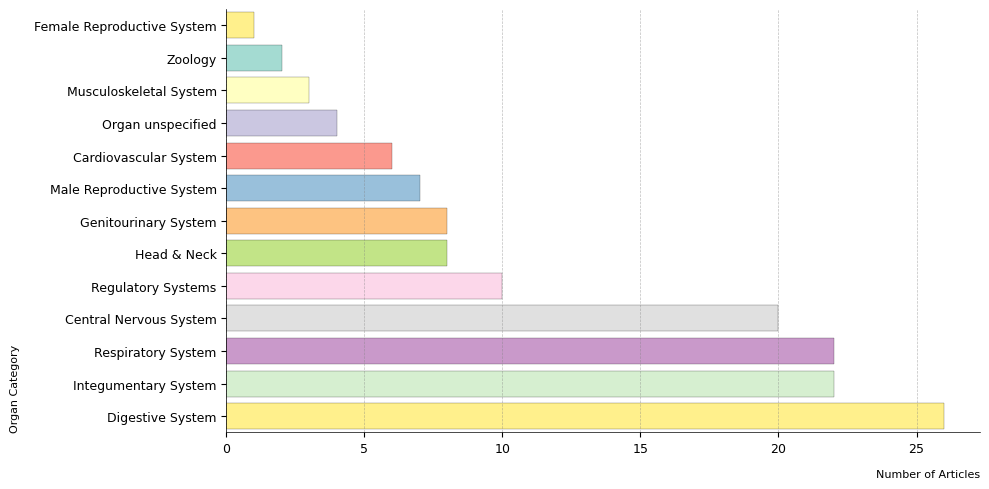

Plot saved to 05MICCAI_notebook_data_visualization/image_type.png


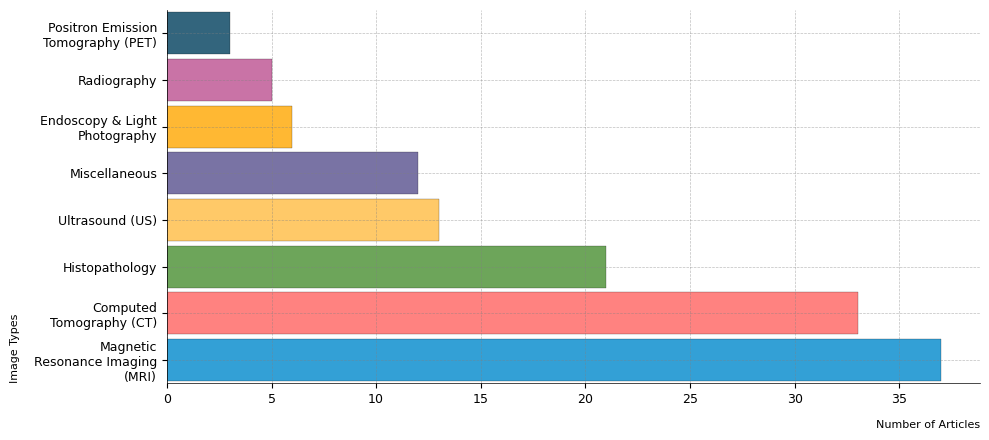

Plot saved to 05MICCAI_notebook_data_visualization/image_type_broad.png


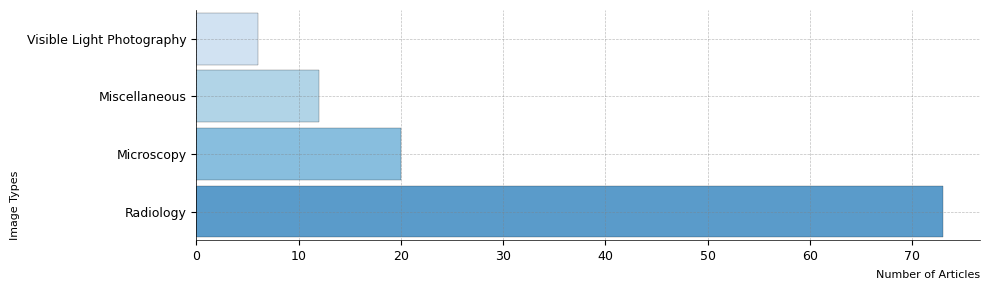

Plot saved to 05MICCAI_notebook_data_visualization/demographics_usage_percentage.png


/var/folders/bn/qvp15lc54w559qnxjpvy0bzw0000gn/T/ipykernel_13366/235533190.py:29: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  legend_handles = [mpatches.Rectangle((0,0),1,1, color=color_scheme[i % len(color_scheme)], edgecolor='black') for i in range(len(category_names))]


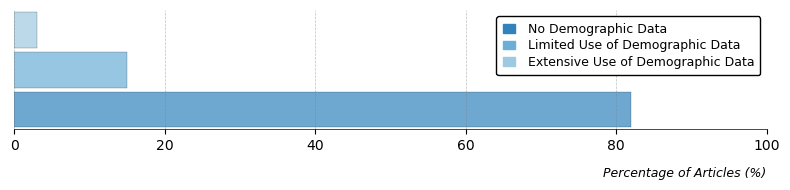

Plot saved to 05MICCAI_notebook_data_visualization/dataset_disclosure.png


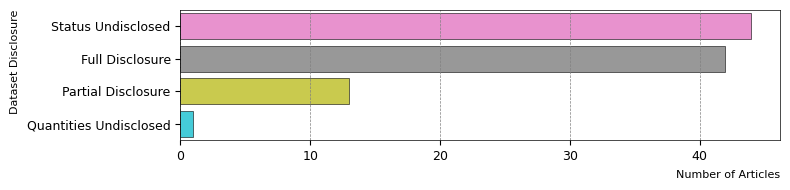

Plot saved to 05MICCAI_notebook_data_visualization/dataset_quantities.png


<Figure size 700x500 with 0 Axes>

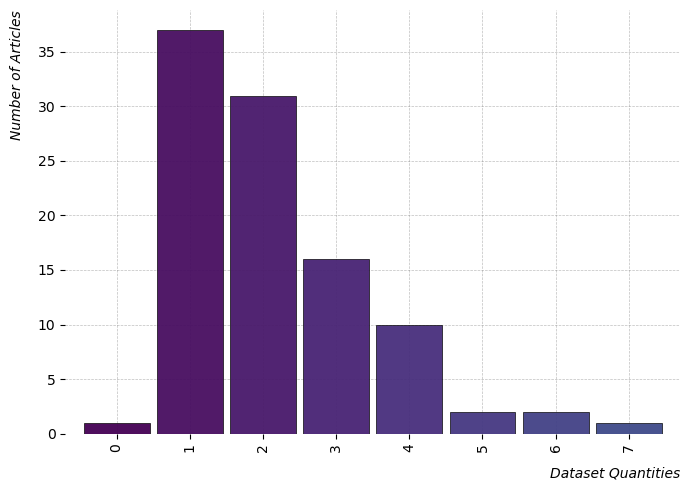

Plot saved to 05MICCAI_notebook_data_visualization/most_dataseta.png


/var/folders/bn/qvp15lc54w559qnxjpvy0bzw0000gn/T/ipykernel_13366/982400482.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


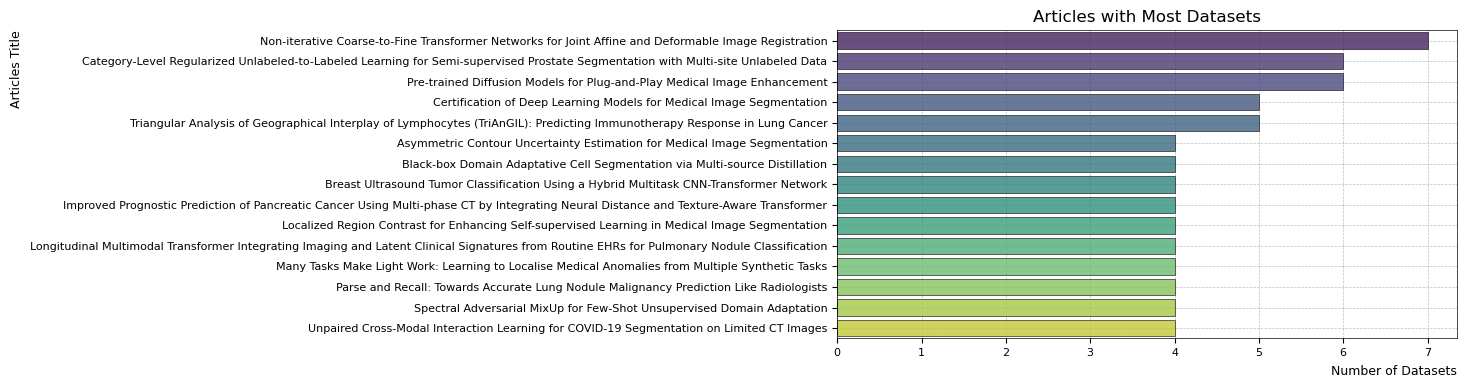

Plot saved to 05MICCAI_notebook_data_visualization/location_percentage_bar_chart.png


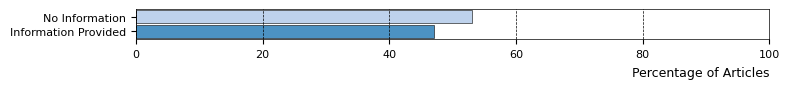

Plot saved to 05MICCAI_notebook_data_visualization/location_category_treemap.png


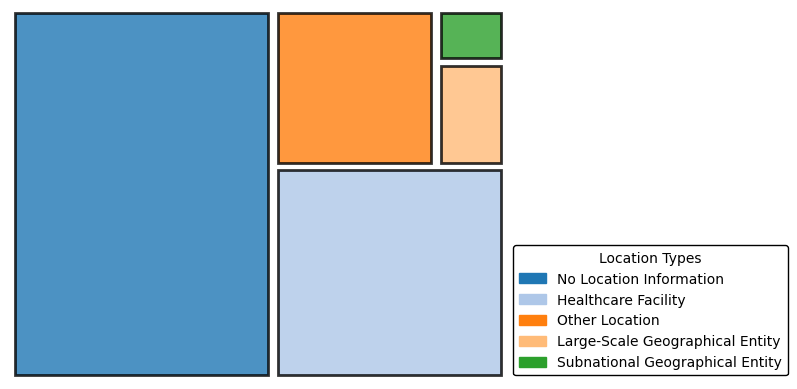

In [20]:
# Using the plotting function for organ categories
plot_distribution_organs(df1, 'organ_category_refined', (10, 5), 'organ_category_refined.png')

# Using the plotting function for image categories
plot_distribution_images(df1, 'image_category', (10, 4.5), 'image_type.png')
plot_distribution_images_broad(df1, 'image_category_broad', (10, 3), 'image_type_broad.png')

# Usage of the function for demographic analysis
# Applying demographic analysis and plotting its distribution
df1['demographics_usage'] = df1.apply(aggregate_demographics, axis=1)
plot_distribution_demographics_usage(df1)

# Usage of the functions for dataset disclosure and status
# Applying dataset disclosure and status analysis and plotting their distribution
df1['dataset_disclosure_category'] = df1.apply(categorize_disclosure, axis=1)
df1['dataset_status'] = df1.apply(categorize_dataset_status, axis=1)
plot_dataset_distribution(df1, 'dataset_disclosure_category')
plot_dataset_quantities(df1)

# Usage of the function for most datasets
plot_most_datasets(df1)

# Usage of the functions for location analysis
# Displaying initial location category data
plot_location_info_distribution(df1)
apply_and_plot_location_categories(df1)

In [21]:
# Count occurrences of preprocessed organ and image types
preprocessed_organ_counts = df1['organ_category_refined'].str.split(',').explode().str.strip().value_counts()
preprocessed_image_type_counts = df1['image_category'].str.split(',').explode().str.strip().value_counts()


unique_image_types_broad = df1['image_category_broad'].str.split(',').explode().str.strip().unique()
preprocessed_image_type_broad_counts = df1['image_category_broad'].str.split(',').explode().str.strip().value_counts()


# Summary statistics
# Compute and print summary statistics
compute_summary_statistics(df1)
compute_demographic_information(df1)
compute_organ_information(df1, organ_counts, unique_organs, preprocessed_organ_counts)
compute_image_information(df1, image_type_counts, unique_image_types, preprocessed_image_type_counts)
compute_broad_image_information(df1, image_type_counts, unique_image_types_broad, preprocessed_image_type_broad_counts)

In [22]:
df1.to_csv(notebook_name + 'preprocessed_annotation_data.csv', index=False)

***
## Analysis of Preprocessed Annotation Data
***

In [23]:
filename = '05MICCAI_notebook_preprocessed_annotation_data.csv'

df1 = pd.read_csv(filename)

### Demographic Distribution
***

In [24]:
def plot_demographic_distribution(df, save_path):
    """Plots the distribution of demographic categories in a given DataFrame."""
    # Define demographics categories
    demographics = ['age', 'sex/gender', 'ethnicity', 'geographical location ']

    # Filter out entries with 'No Demographic Data'
    df_filtered = df[df['demographics_usage'] != 'No Demographic Data']

    # Create dummy variables for demographics categories
    df_dummy_filtered = pd.get_dummies(df_filtered[demographics])

    # Summing up the dummies under each 'demographics_usage' category
    pivot_df = df_dummy_filtered.groupby(df_filtered['demographics_usage']).sum()

    # Define labels for the plot
    labels_demo = ['Age', 'Sex/Gender', 'Ethnicity', 'Geographical Location']

    # Plotting the data in a stacked bar chart format
    #fig, ax = plt.subplots(figsize=(10, 3.6))
    fig, ax = plt.subplots(figsize=(10, 4.5))
    
    colors = sns.color_palette("Blues", len(labels_demo))


    pivot_df.plot(kind='barh', stacked=True, color=colors, width=0.9, edgecolor='black', linewidth=0.2, alpha=0.8, ax=ax)

    # Customizing the plot appearance
    ax.set_ylabel('Demographic Usage', loc='top', fontsize=12, labelpad=15)
    ax.set_xlabel('Distribution of Demographic Sub Categories', loc='right', fontsize=12, labelpad=15)
    # ax.set_yticklabels(['Extensive Use', 'Limited Use'], fontsize=12, rotation=0, va='center')
    ax.set_yticklabels(['Extensive', 'Limited'], fontsize=12, rotation=90, va='center')

    
    # Setting the legend
    ax.legend(labels=labels_demo, loc='lower right', bbox_to_anchor=(0.95, 0.08), 
              fontsize='11.5', title_fontsize='small', title='Demographic Sub Categories', 
              shadow=False, fancybox=True, ncol=1, frameon=True, edgecolor='black', framealpha=1, borderpad=0.5, labelspacing=0.3, handlelength=1.5, 
              handletextpad=0.5, handleheight=1.5)

    
    # Enhancing grid visibility and aesthetics 
    plt.grid(axis='x', linestyle='--', which='both', color='gray', alpha=0.5)
 
    # Remove the frame of the plot
    ax.spines['top'].set_visible(False)  # Remove the top spine
    ax.spines['right'].set_visible(False)  # Remove the right spine
    ax.spines['left'].set_visible(False)  # Remove the left spine
    ax.spines['bottom'].set_visible(False)  # Remove the bottom spine

    # Tight layout and save figure
    save_plot_to_folder(plt, save_path) # Save the plot to the plots folder
    plt.tight_layout()
    plt.show()

### Organs and Demographics
***

In [25]:
def analyze_organ_distribution_no_demographics(df, organ_column, demo_usage_column, save_path_base, organ_mapping=organ_mapping):
    """Analyzes and plots the distribution of organs where no demographic data is provided."""

    # Expand and explode the organ categories
    df[organ_column] = df[organ_column].str.split(', ')
    df_expanded = df.explode(organ_column)

    df_expanded[organ_column] = df_expanded[organ_column].map(organ_mapping).fillna(df_expanded[organ_column])

    # Filter for 'No Demographic Data'
    no_demo_data = df_expanded[df_expanded[demo_usage_column] == 'No Demographic Data']

    # Group by organ and count occurrences
    grouped_no_demo = no_demo_data.groupby(organ_column).size().reset_index(name='Count')
    grouped_no_demo_sorted = grouped_no_demo.sort_values('Count', ascending=False)

    #grouped_no_demo_sorted['Percentage'] = grouped_no_demo_sorted['Count'] / grouped_no_demo_sorted['Count'].sum() * 100

    # Plotting the details for 'No Demographic Data' with horizontal bars
    colors = plt.cm.Set3_r.colors[:len(grouped_no_demo_sorted)]
    
    plt.figure(figsize=(10, 3.5))
    #plt.barh(grouped_no_demo_sorted[organ_column], grouped_no_demo_sorted['Percentage'], color=colors, edgecolor='black', linewidth=0.5, alpha=0.8, height=0.8)
    plt.barh(grouped_no_demo_sorted[organ_column], grouped_no_demo_sorted['Count'], color=colors, edgecolor='black', linewidth=0.5, alpha=0.8, height=0.8)

    plt.title('Distribution of Organs in Articles with No Demographic Data', fontsize=10, loc='center')
    
    #plt.xlabel('Percentage of Articles (%)', fontsize=10, labelpad=10, loc='right', style='italic')
    plt.xlabel('Number of Articles', fontsize=9.5, labelpad=10, loc='right', style='italic')
    plt.ylabel('Main Organ Category', fontsize=9.5, labelpad=10, loc='center', style='italic')
    
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)

    plt.grid(axis='x', linestyle='--', which='both', color='gray', alpha=0.5)
    
    #plt.savefig(f'{save_path_base}_no_demographic_data.png', dpi=300, bbox_inches='tight', transparent=True)
    save_plot_to_folder(plt, f'{save_path_base}_no_demographic_data.png') # Save the plot to the plots folder
    plt.tight_layout()
    plt.show()

In [26]:
def analyze_organ_distribution_extensive_use_demographics(df, organ_column, demo_usage_column, save_path_base, organ_mapping=organ_mapping):
    """Analyzes and plots the distribution of organs where extensive demographic data is provided."""

    # Expand and explode the organ categories
    df[organ_column] = df[organ_column].str.split(', ')
    df_expanded = df.explode(organ_column)

    df_expanded[organ_column] = df_expanded[organ_column].map(organ_mapping).fillna(df_expanded[organ_column])

    # Filter for 'Extensive Demographic Data'
    extensive_demo_data = df_expanded[df_expanded[demo_usage_column] == 'Extensive Use of Demographic Data']

    # Group by organ and count occurrences
    grouped_extensive_demo = extensive_demo_data.groupby(organ_column).size().reset_index(name='Count')
    grouped_extensive_demo_sorted = grouped_extensive_demo.sort_values('Count', ascending=False)
    #grouped_extensive_demo_sorted['Percentage'] = grouped_extensive_demo_sorted['Count'] / grouped_extensive_demo_sorted['Count'].sum() * 100

    # Plotting the details for 'Extensive Demographic Data' with horizontal bars
    colors = plt.cm.Set3_r.colors[:len(grouped_extensive_demo_sorted)]

    plt.figure(figsize=(10, 3.))
    
    #plt.barh(grouped_extensive_demo_sorted[organ_column], grouped_extensive_demo_sorted['Percentage'], color=colors,edgecolor='black', linewidth=0.5, alpha=0.8, height=0.8)
    plt.barh(grouped_extensive_demo_sorted[organ_column], grouped_extensive_demo_sorted['Count'], color=colors,edgecolor='black', linewidth=0.5, alpha=0.8, height=0.8)

    plt.title('Distribution of Organs in Articles with Extensive Use of Demographic Data', fontsize=10, loc='center')
    #plt.xlabel('Percentage of Articles (%)', fontsize=10, labelpad=10, loc='right', style='italic')
    plt.xlabel('Number of Articles', fontsize=9.5, labelpad=10, loc='right', style='italic')
    plt.ylabel('Main Organ Category', fontsize=9.5, labelpad=10, loc='center', style='italic')
    
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=9)
    #plt.xticks(range(0, int(3) + 1, 1))

    plt.grid(axis='x', linestyle='--', which='both', color='gray', alpha=0.5)
    
    #plt.savefig(f'{save_path_base}_extensive_use_of_demographic_data.png', dpi=300, bbox_inches='tight', transparent=True)
    save_plot_to_folder(plt, f'{save_path_base}_extensive_use_of_demographic_data.png') # Save the plot to the plots folder
    plt.tight_layout()
    plt.show()

In [27]:
def plot_organ_distribution_by_demographics(df, organ_column, demo_usage_column, save_path):
    """
    Plots a stacked bar chart of the distribution of organ categories across different demographic usage.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    organ_column (str): The column name for the organ categories.
    demo_usage_column (str): The column name for demographic usage.
    save_path (str): The path to save the plot image.
    """

    # Expand the 'organ_category_refined' to separate rows for each category
    df_expanded = df.drop(organ_column, axis=1).join(df[organ_column].str.split(', ').explode().reset_index(drop=True))

    # Group by 'demographics_usage' and the expanded 'organ_category_refined', then count each group
    grouped = df_expanded.groupby([demo_usage_column, organ_column]).size().reset_index(name='Count')

    # Pivot data to get 'organ_category_refined' categories as columns filled with counts
    pivot_df = grouped.pivot_table(index=demo_usage_column, columns=organ_column, values='Count', fill_value=0)

    # Plotting the horizontal stacked bar chart
    colors = plt.cm.Set3_r.colors[:len(pivot_df.columns)]

    # Plotting the horizontal stacked bar chart
    ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 8), color=colors, width=0.95, edgecolor='black', linewidth=0.5, alpha=0.8)
    
    plt.ylabel('Distribution of Organs', fontsize=10, labelpad=10, loc='top', style='italic').set_visible(True)
    plt.xlabel('Demographics Usage', fontsize=10, labelpad=10, loc='right', style='italic' ).set_visible(True)
    
    ax.set_xticklabels(['Extensive Use', 'Limited Use', 'No Use'], fontsize=11, rotation=0, fontweight='bold', va='top')
    plt.legend(loc='upper left', fontsize='12.5', shadow=False, fancybox=True, ncol=1, frameon=True, edgecolor='black', framealpha=1, borderpad=0.5,
               labelspacing=0.5, handlelength=1., handletextpad=0.5, handleheight=1.)
    
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlim(-0.49, 2.49)
    
    plt.grid(axis='x', linestyle='--', which='both', color='gray', alpha=0.5)

    #plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True)
    save_plot_to_folder(plt, save_path) # Save the plot to the plots folder
    plt.tight_layout()
    plt.show()

### Image types and Demographics
***

In [28]:
from cProfile import label

def plot_image_distribution_by_demographics(df, image_column, demo_usage_column, save_path):
    """
    Plots a stacked bar chart of the distribution of image types categories across different demographic usage.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    image_column (str): The column name for the organ categories.
    demo_usage_column (str): The column name for demographic usage.
    save_path (str): The path to save the plot image.
    """

    # Expand the 'image_col' to separate rows for each category
    df_expanded = df.drop(image_column, axis=1).join(df[image_column].str.split(', ').explode().reset_index(drop=True))

    # Group by 'demographics_usage' and the expanded 'image_col', then count each group
    grouped = df_expanded.groupby([demo_usage_column, image_column]).size().reset_index(name='Count')

    # Pivot data to get 'organ_category_refined' categories as columns filled with counts
    pivot_df = grouped.pivot_table(index=demo_usage_column, columns=image_column, values='Count', fill_value=0)

    # Plotting the horizontal stacked bar chart
    colors = plt.cm.tab20c.colors  # Or any other colormap that you like

    # Plotting the horizontal stacked bar chart
    ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 8), color=colors, width=0.95, edgecolor='black', linewidth=0.5, alpha=0.8)

    plt.ylabel('Distribution of Image Types', fontsize=12, labelpad=15, loc='top', style='italic').set_visible(True)
    plt.xlabel('Demographic Usage', fontsize=12, labelpad=15, loc='right', style='italic').set_visible(True)
    
    ax.set_xticklabels(['Extensive Use', 'Limited Use', 'No Use'], fontsize=11, rotation=0, fontweight='bold')
    plt.xlim(-0.49, 2.49)
    
    plt.legend(fontsize='12.5', loc='upper left', shadow=False, fancybox=True, ncol=1, frameon=True, edgecolor='black', framealpha=1, borderpad=0.5,
               labelspacing=0.5, handlelength=1., handletextpad=0.5, handleheight=1.)
    
    plt.grid(axis='x', linestyle='--', which='both', color='gray', alpha=0.5)
    
    #plt.savefig('image_types_by_demographics.png', dpi=300, bbox_inches='tight', transparent=True)
    save_plot_to_folder(plt, save_path) # Save the plot to the plots folder
    plt.tight_layout()
    plt.show()

### Location and Demographics
***

In [29]:
def plot_location_distribution_by_demographics(df, demo_column, location_column, save_path):
    """
    Plots a stacked bar chart of the distribution of location categories across different demographic usages.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    demo_column (str): The column name for the demographic usages.
    location_column (str): The column name for the location categories.
    save_path (str): The path to save the plot image.
    """
    colors = plt.cm.Accent_r.colors[3:]

    # Group by 'Demographic' and 'Location', then count each group
    grouped = df.groupby([demo_column, location_column]).size().reset_index(name='Count')

    # Pivot data to get 'Location' categories as columns filled with counts
    pivot_df = grouped.pivot_table(index=demo_column, columns=location_column, values='Count', fill_value=0)

    # Plotting
    ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 8), color=colors, width=0.95, edgecolor='black', linewidth=0.5, alpha=0.8)

    plt.xlabel('Demographic Usage', fontsize=12, labelpad=15, loc='right', style='italic')
    plt.ylabel('Distribution of Location Types', fontsize=12, labelpad=15, loc='top', style='italic')
    
    ax.set_xticklabels(['Extensive Use', 'Limited Use', 'No Use'], fontsize=11, rotation=0, fontweight='bold')
    plt.xlim(-0.5, len(pivot_df.index)-0.5)
    
    plt.legend(loc='upper left', fontsize='12.5', title_fontsize='small', shadow=False, fancybox=True, ncol=1, frameon=True, edgecolor='black', 
               framealpha=1, borderpad=0.5, labelspacing=0.5, handlelength=1., handletextpad=0.5, handleheight=1.)
    
    plt.grid(axis='x', linestyle='--', which='both', color='gray', alpha=0.5)
    
    #plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True)
    save_plot_to_folder(plt, save_path) # Save the plot to the plots folder
    plt.tight_layout()
    plt.show()

### Dataset and Demographics
***

In [30]:
def plot_dataset_disclosure_by_demographics(df, demo_column, disclosure_column, save_path):
    """
    Plots a horizontal stacked bar chart showing the distribution of dataset disclosure categories across demographic usage types.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    demo_column (str): The column name for demographic usages.
    disclosure_column (str): The column name for dataset disclosure categories.
    save_path (str): The path to save the plot image.
    """
    colors = plt.cm.tab20.colors

    # Group by demographic usage and dataset disclosure categories, then count each group
    grouped = df.groupby([demo_column, disclosure_column]).size().reset_index(name='Count')

    # Pivot data to get dataset disclosure categories as columns filled with counts
    pivot_df = grouped.pivot_table(index=demo_column, columns=disclosure_column, values='Count', fill_value=0).sort_values(by=demo_column, ascending=False)

    # Plotting
    ax = pivot_df.plot(kind='barh', stacked=True, figsize=(10, 4), color=colors, width=0.95, edgecolor='black', linewidth=0.3, alpha=0.8)

    plt.xlabel('Distribution of Dataset Disclosure', fontsize=12, labelpad=15, loc='right')
    plt.ylabel('Demographic Usage', fontsize=12, labelpad=15, loc='top')
    
    #ax.set_yticklabels(['Extensive Use', 'Limited Use', 'No Use'], fontsize=11, rotation=0)
    ax.set_yticklabels(['None', 'Limited', 'Extensive'], fontsize=11, rotation=90, va='center')
    
    plt.xlim(0, 100)
    plt.ylim(-0.49, len(pivot_df.index)-0.49)
    
    plt.legend(loc='upper right', fontsize='11.5', shadow=False, fancybox=True, ncol=1, frameon=True, edgecolor='black', framealpha=1, borderpad=0.5,
               labelspacing=0.3, handlelength=1., handletextpad=0.5, handleheight=1.)
    
    plt.grid(axis='x', linestyle='--', which='both', color='gray', alpha=0.5)
    # Remove the frame of the plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(True)

    #plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True)
    save_plot_to_folder(plt, save_path) # Save the plot to the plots folder
    plt.tight_layout()
    plt.show()

In [31]:
def plot_dataset_quantity_by_demographics(df, demo_column, dataset_column, save_path):
    """
    Plots a bar chart showing the distribution of the number of datasets used by papers, categorized by demographics usage.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    demo_column (str): The column name for demographic usages.
    dataset_column (str): The column name for dataset quantity.
    save_path (str): The path to save the plot image.
    """
    
    # Group by demographic usage and dataset quantity, then count each group
    #grouped = df.groupby([demo_column, dataset_column]).size().reset_index(name='Count')
    grouped = df.groupby([dataset_column, demo_column]).size().reset_index(name='Count')

    # Pivot data to get dataset quantities as columns filled with counts
    #pivot_df = grouped.pivot_table(index=demo_column, columns=dataset_column, values='Count', fill_value=0)
    pivot_df = grouped.pivot_table(index=dataset_column, columns=demo_column, values='Count', fill_value=0)
    
    #colors = plt.cm.tab20c_r.colors[5:]
    fig, ax = plt.subplots(figsize=(7, 5))
    colors = plt.cm.Set3_r(np.linspace(0, 1, pivot_df.shape[0]))  # Using a viridis color map for better color distribution

    # Dataset quantity labels
    #dataset_labels = [f'{i} Dataset' if i == 1 else f'{i} Datasets' for i in range(1, 8)]
    dataset_labels = [f'{i} Dataset' for i in range(1, 8)]

    # Plotting
    ax = pivot_df.plot(kind='bar', stacked=True, ax=ax, color=colors[:pivot_df.shape[0]], width=1, edgecolor='black', linewidth=0.5, alpha=0.7)

    plt.xlabel('Dataset Quantities', fontsize=10, labelpad=15, loc='right')
    plt.ylabel('Number of Articles', fontsize=10, labelpad=15, loc='top')
    #plt.ylabel('Distribution of Datasets', fontsize=12, labelpad=15, loc='top', style='italic')
    
    plt.xlim(0.49, 7.5)
    plt.ylim(0, 40)

   
    plt.legend(loc='upper right', fontsize='11', shadow=False, fancybox=True, ncol=1, frameon=True, edgecolor='black', framealpha=1, 
               borderpad=0.5,labelspacing=0.5, handlelength=1.5, handletextpad=0.5, handleheight=1.5)
    
    plt.grid(True, linestyle='--', which='both', color='gray', alpha=0.5, linewidth=0.5)
    
    # Remove the frame of the plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)

    #plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True)
    save_plot_to_folder(plt, save_path) # Save the plot to the plots folder
    plt.tight_layout()
    plt.show()

In [32]:
# import matplotlib.pyplot as plt

# def plot_dataset_quantity_by_demographics_2(df, demo_column, dataset_column, save_path):
#     """
#     Plots a bar chart showing the distribution of the number of datasets used by papers, categorized by demographics usage.

#     Parameters:
#     df (DataFrame): The DataFrame containing the data.
#     demo_column (str): The column name for demographic usages.
#     dataset_column (str): The column name for dataset quantity.
#     save_path (str): The path to save the plot image.
#     """
#     #colors = plt.cm.tab20c_r.colors[5:]

#     # Group by demographic usage and dataset quantity, then count each group
#     grouped = df.groupby([demo_column, dataset_column]).size().reset_index(name='Count')

#     # Pivot data to get demographic usages as rows and dataset quantities as columns
#     pivot_df = grouped.pivot_table(index=demo_column, columns=dataset_column, values='Count', fill_value=0)
#     fig, ax = plt.subplots(figsize=(7, 5))
#     colors = plt.cm.viridis(np.linspace(0, 1, pivot_df.shape[1]))  # Using a viridis color map for better color distribution

#     #pivot_df.plot(kind='bar', stacked=True, color=colors, ax=ax, width=0.95, edgecolor='black', linewidth=0.5)

#     # Plotting
#     pivot_df.plot(kind='bar', stacked=True, ax=ax, color=colors[:pivot_df.shape[1]], width=0.95, edgecolor='black', linewidth=0.5, alpha=0.9)

#     #plt.xlabel('Quantity Of Dataset Used Per Article', fontsize=10, labelpad=15, loc='right', style='italic')
#     plt.xlabel('Demographic Usage', fontsize=10, labelpad=15, loc='right', style='italic')
#     plt.ylabel('Number of Articles', fontsize=10, labelpad=15, loc='top', style='italic')

#     # Dynamically create dataset labels based on the unique dataset quantities
#     dataset_labels = [f'{i} Dataset' if i == 1 else f'{i} Datasets' for i in sorted(pivot_df.columns)]
#     ax.set_xticklabels(['Extensive Use', 'Limited Use', 'No Use'], fontsize=11, rotation=0, fontweight='bold')

#     plt.legend(title="Dataset Quantities", labels=dataset_labels, loc='upper left', fontsize='11.5', shadow=False, fancybox=True, ncol=1, frameon=True,
#                edgecolor='black', framealpha=1, borderpad=0.5, labelspacing=0.5, handlelength=1.5, handletextpad=0.5, handleheight=1.5)

#     # Adding grid lines
#     ax.grid(True, linestyle='--', which='both', color='gray', alpha=0.5)
#     ax.set_axisbelow(True)
    
#     save_plot_to_folder(plt, save_path) # Save the plot to the plots folder
#     plt.tight_layout()
#     plt.show()

#### Plotting the distribution of organs by dataset quantities
***

Total number of articles using exactly one dataset: 37
Total number of unique organ types researched: 21


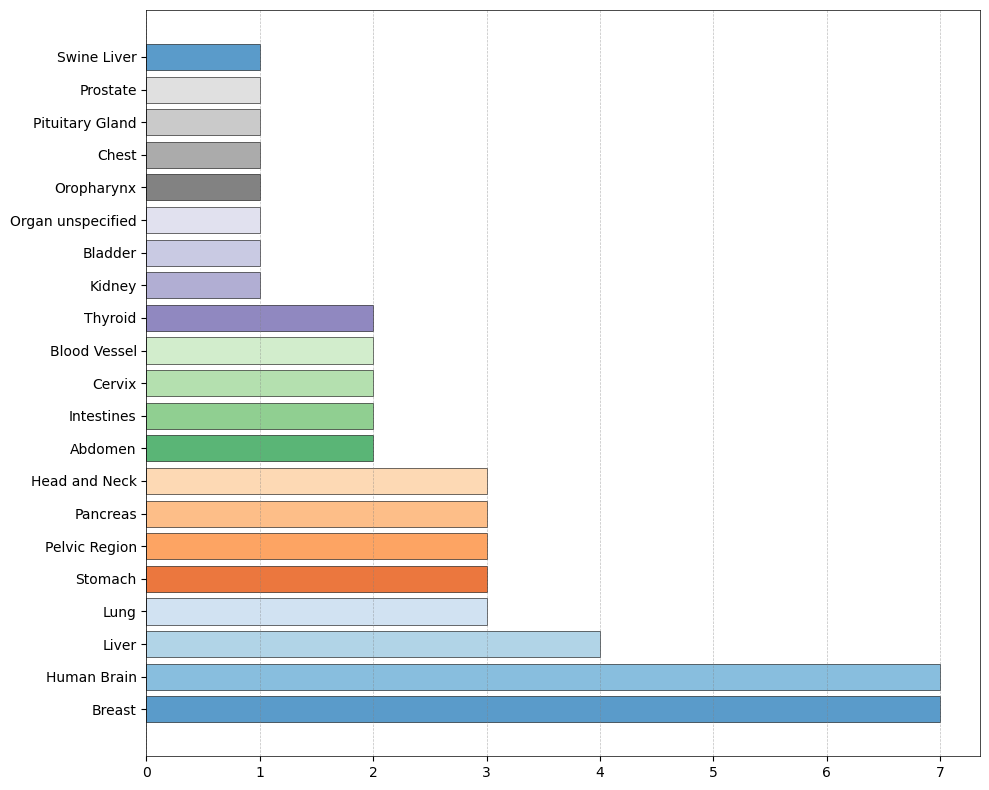

In [33]:
# Plotting the distribution of organs by dataset quantities
df1['organ_types'] = df1['organ/body part in datasets'].str.strip('[]').str.replace("'", "").str.split(', ')

# Filter the data for articles where exactly one dataset is used
single_dataset_df = df1[df1['dataset quantity'] == 1]

# Explode the DataFrame on 'organ_types' after filtering
df_expanded = single_dataset_df.explode('organ_types')

# Replace organ names in the DataFrame with standardized names using the mapping
df_expanded['organ_types'] = df_expanded['organ_types'].apply(lambda x: organ_mapping.get(x, x))

# Regroup by 'organ_types' and count occurrences
grouped_organ_dataset = df_expanded.groupby('organ_types').size().reset_index(name='Count')

print(f'Total number of articles using exactly one dataset: {len(single_dataset_df)}')
print(f'Total number of unique organ types researched: {len(grouped_organ_dataset)}')

# Sort the DataFrame based on 'Count' to make the plot more readable
grouped_organ_dataset_sorted = grouped_organ_dataset.sort_values('Count', ascending=False)

# Define colors for the plot
colors = plt.cm.tab20c.colors[:len(grouped_organ_dataset_sorted)]

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(grouped_organ_dataset_sorted['organ_types'], grouped_organ_dataset_sorted['Count'], color=colors, edgecolor='black', linewidth=0.5, alpha=0.8, height=0.8)
plt.grid(axis='x', linestyle='--', which='both', color='gray', alpha=0.5)
plt.tight_layout()
plt.show()

Plot saved to 05MICCAI_notebook_data_visualization/heatmap_organ_types.png


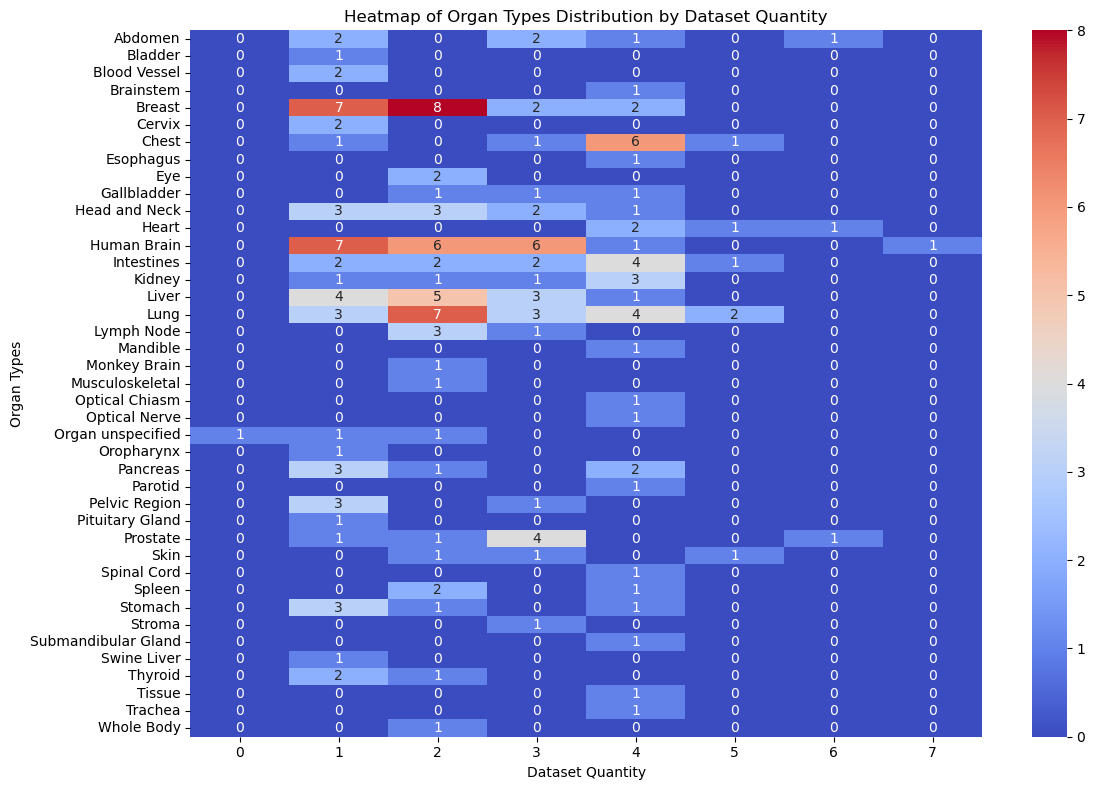

In [34]:
np.random.seed(0)
df1['organ_types'] = df1['organ/body part in datasets'].str.strip('[]').str.replace("'", "").str.split(', ')

# Explode the DataFrame on 'organ_types' after filtering
df_expanded = df1.explode('organ_types')

df_expanded['organ_types'] = df_expanded['organ_types'].apply(lambda x: organ_mapping.get(x, x))


# Aggregate data for heatmap
heatmap_data = df_expanded.groupby(['organ_types', 'dataset quantity']).size().unstack(fill_value=0)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='d')
plt.title('Heatmap of Organ Types Distribution by Dataset Quantity')
plt.ylabel('Organ Types')
plt.xlabel('Dataset Quantity')
plt.tight_layout()
save_plot_to_folder(plt, 'heatmap_organ_types.png') # Save the plot to the plots folder
plt.show()


Total number of articles using 3 or more datasets: 31
Total number of unique organ types researched: 29


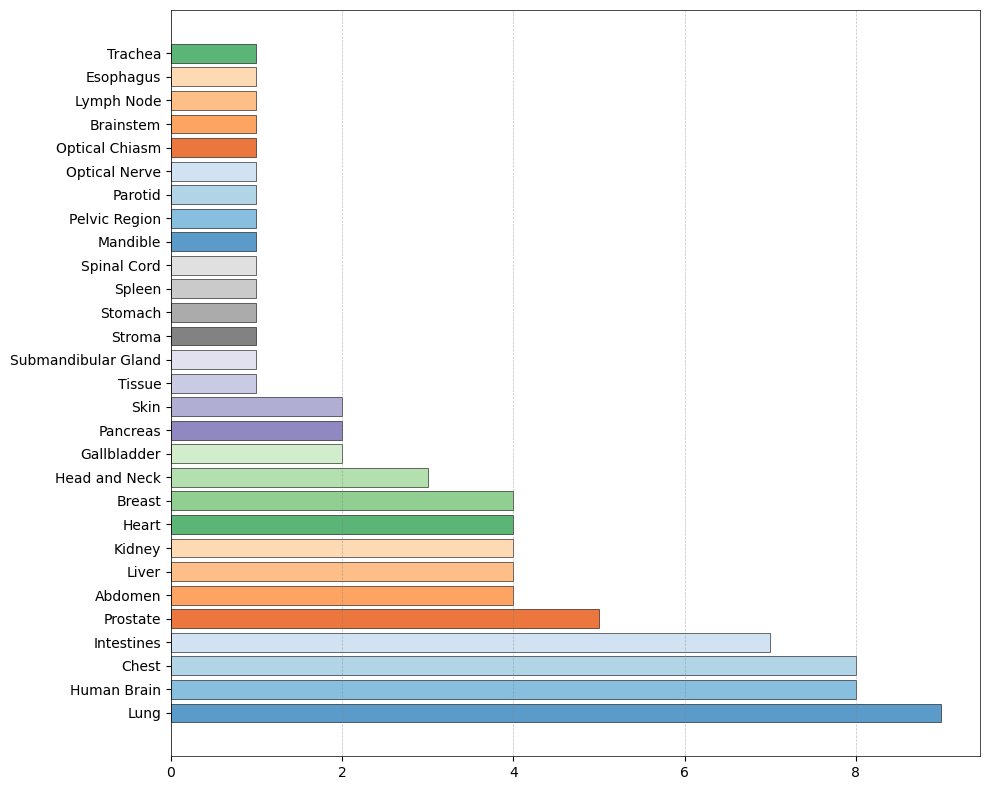

In [35]:
# Plotting the distribution of organs by dataset quantities
df1['organ_types'] = df1['organ/body part in datasets'].str.strip('[]').str.replace("'", "").str.split(', ')

# Filter the data for articles where exactly one dataset is used
plus_three_dataset_df = df1[df1['dataset quantity'] >=3]

# Explode the DataFrame on 'organ_types' after filtering
df_expanded = plus_three_dataset_df.explode('organ_types')

# Replace organ names in the DataFrame with standardized names using the mapping
df_expanded['organ_types'] = df_expanded['organ_types'].apply(lambda x: organ_mapping.get(x, x))

# Regroup by 'organ_types' and count occurrences
grouped_organ_dataset = df_expanded.groupby('organ_types').size().reset_index(name='Count')

print(f'Total number of articles using 3 or more datasets: {len(plus_three_dataset_df)}')
print(f'Total number of unique organ types researched: {len(grouped_organ_dataset)}')

# Sort the DataFrame based on 'Count' to make the plot more readable
grouped_organ_dataset_sorted = grouped_organ_dataset.sort_values('Count', ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(grouped_organ_dataset_sorted['organ_types'], grouped_organ_dataset_sorted['Count'], color=colors, edgecolor='black', linewidth=0.5, alpha=0.8, height=0.8)
plt.grid(axis='x', linestyle='--', which='both', color='gray', alpha=0.5)
plt.tight_layout()
plt.show()

In [36]:
# Read the cleaned annotation data
filename = '05MICCAI_notebook_preprocessed_annotation_data.csv'
df1 = pd.read_csv(filename)

### Distribution of Organ Categories and Individual Organs By Demographic Usage
***

Plot saved to 05MICCAI_notebook_data_visualization/demographics_stacked_bar_chart.png


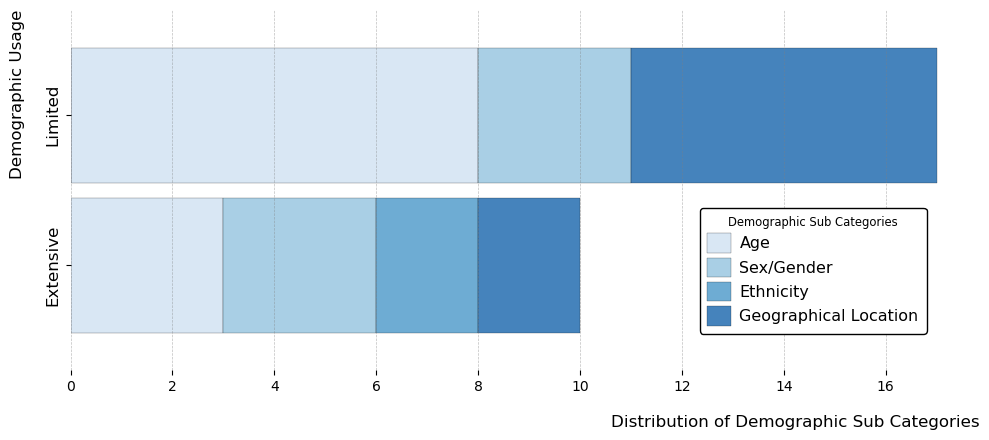

In [37]:
# Usage of the function for demographic analysis
plot_demographic_distribution(df1, 'demographics_stacked_bar_chart.png')

Plot saved to 05MICCAI_notebook_data_visualization/organs_by_demographics.png


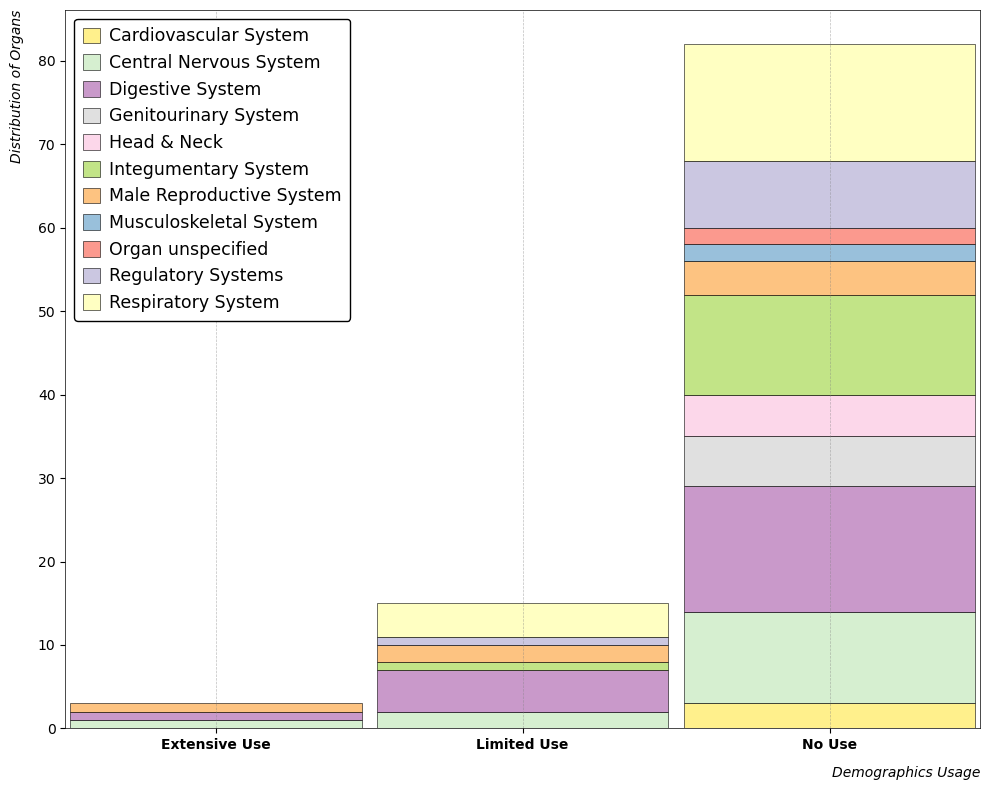

Plot saved to 05MICCAI_notebook_data_visualization/image_by_demographics.png


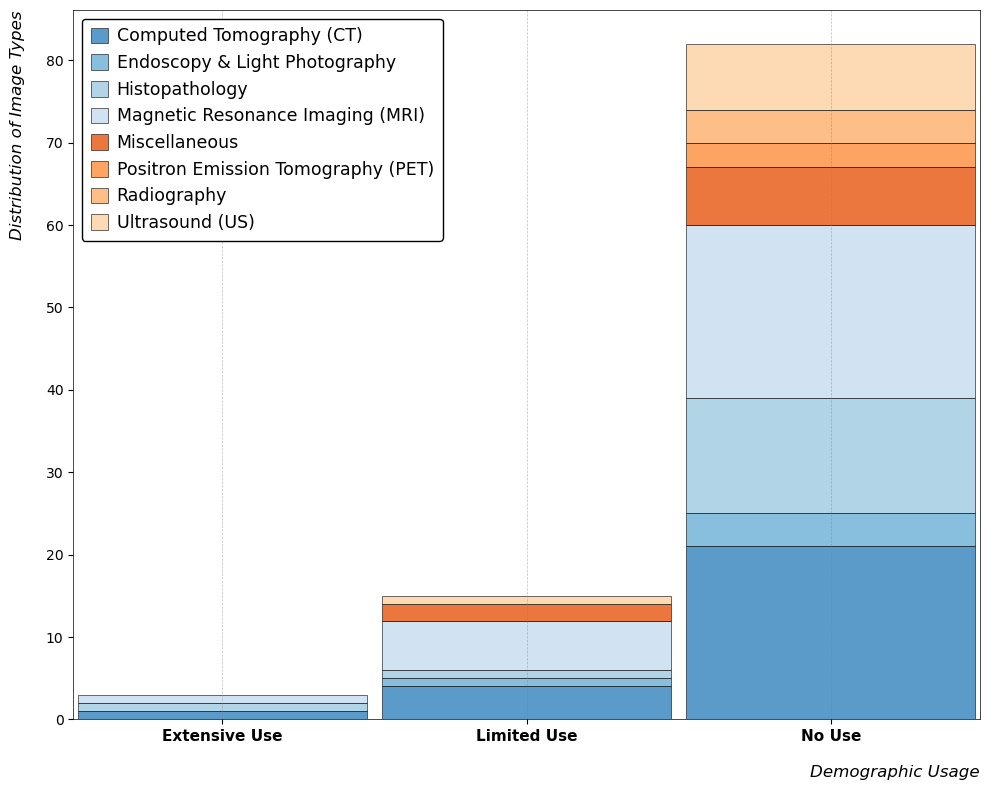

Plot saved to 05MICCAI_notebook_data_visualization/location_types_by_demographics.png


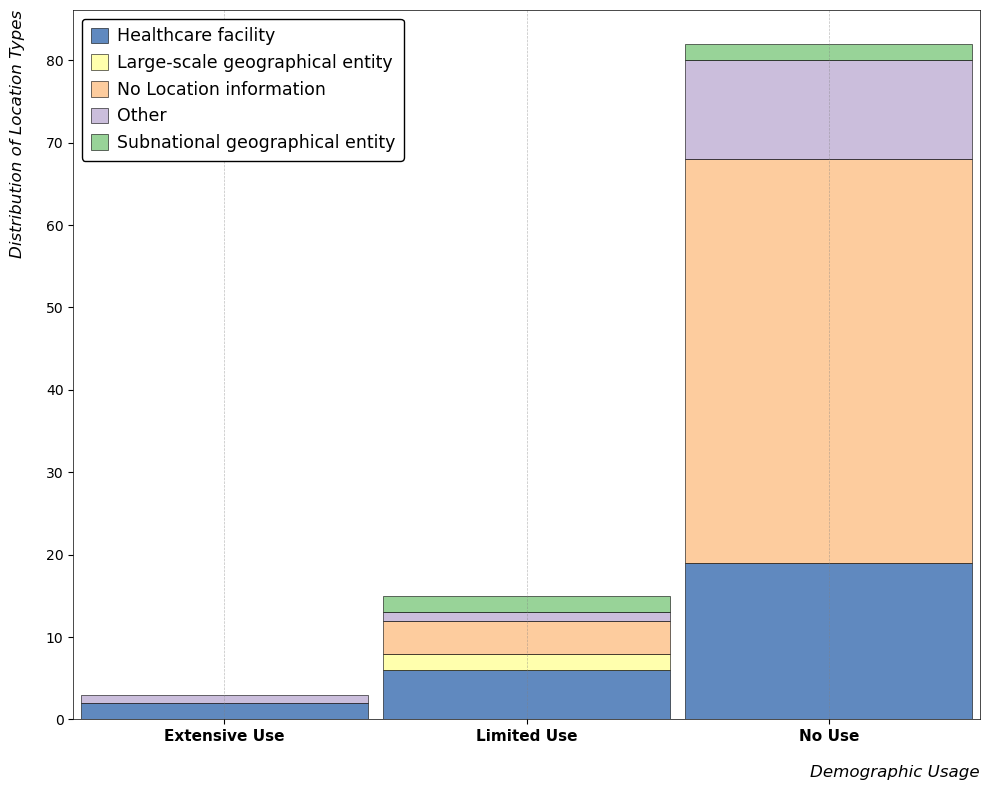

Plot saved to 05MICCAI_notebook_data_visualization/dataset_disclosure_by_demographics.png


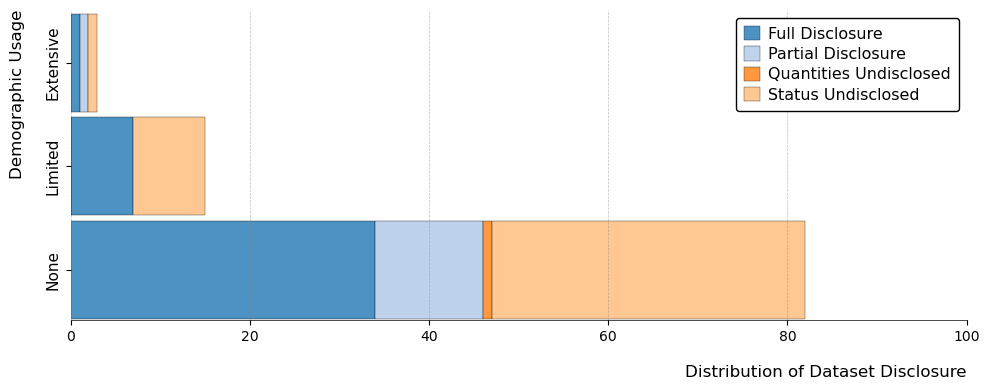

Plot saved to 05MICCAI_notebook_data_visualization/dataset_quantity_by_demographics_.png


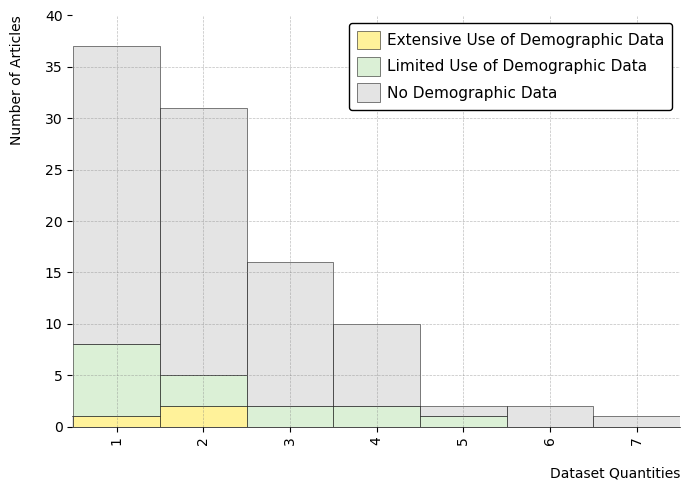

In [38]:
# Read the cleaned annotation data
df1 = pd.read_csv(filename)

# Usage of the function for organ distribution analysis
plot_organ_distribution_by_demographics(df1, 'organ_category_refined', 'demographics_usage', 'organs_by_demographics.png')

# Usage of the function for organ distribution analysis
plot_image_distribution_by_demographics(df1, 'image_category', 'demographics_usage', 'image_by_demographics.png')

# Usage of the function for location distribution analysis
plot_location_distribution_by_demographics(df1, 'demographics_usage', 'location_category', 'location_types_by_demographics.png')
# Usage of the function for dataset disclosure analysis
plot_dataset_disclosure_by_demographics(df1, 'demographics_usage', 'dataset_disclosure_category', 'dataset_disclosure_by_demographics.png')

# Usage of the function for dataset quantity analysis
plot_dataset_quantity_by_demographics(df1, 'demographics_usage', 'dataset quantity', 'dataset_quantity_by_demographics_.png')
#plot_dataset_quantity_by_demographics_2(df1, 'demographics_usage', 'dataset quantity', 'dataset_quantity_by_demographics_2.png')

#### Group individual organs by No Demographic Data
***

Plot saved to 05MICCAI_notebook_data_visualization/organs_distribution_no_demographic_data.png


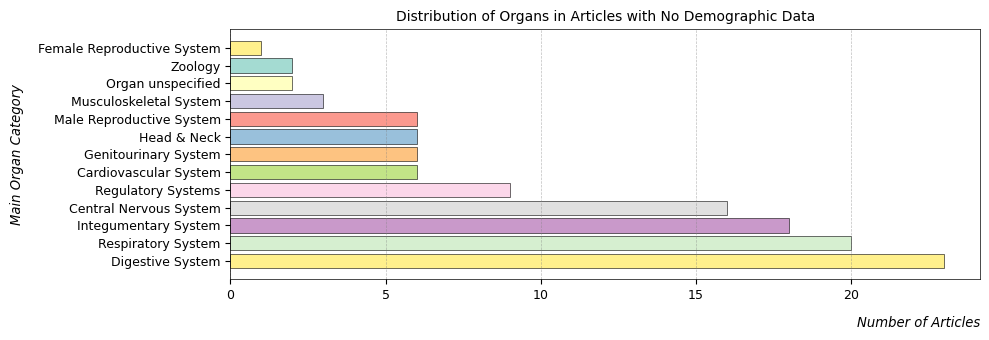

Plot saved to 05MICCAI_notebook_data_visualization/organs_distribution_extensive_use_of_demographic_data.png


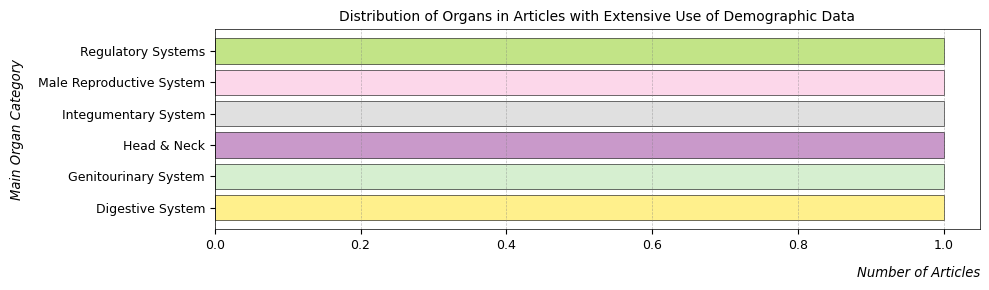

In [39]:
# Usage of the function for organ distribution analysis
analyze_organ_distribution_no_demographics(df1, 'organ_category_refined', 'demographics_usage', 'organs_distribution')

# Read the cleaned annotation data
df1 = pd.read_csv(filename)
analyze_organ_distribution_extensive_use_demographics(df1, 'organ_category_refined', 'demographics_usage', 'organs_distribution')

In [40]:
# Prepare 'organ_types' by removing brackets and quotes, then splitting and exploding
df1['organ_types'] = df1['organ/body part in datasets'].str.strip('[]').str.replace("'", "").str.split(', ')
df_expanded = df1.explode('organ_types')

40


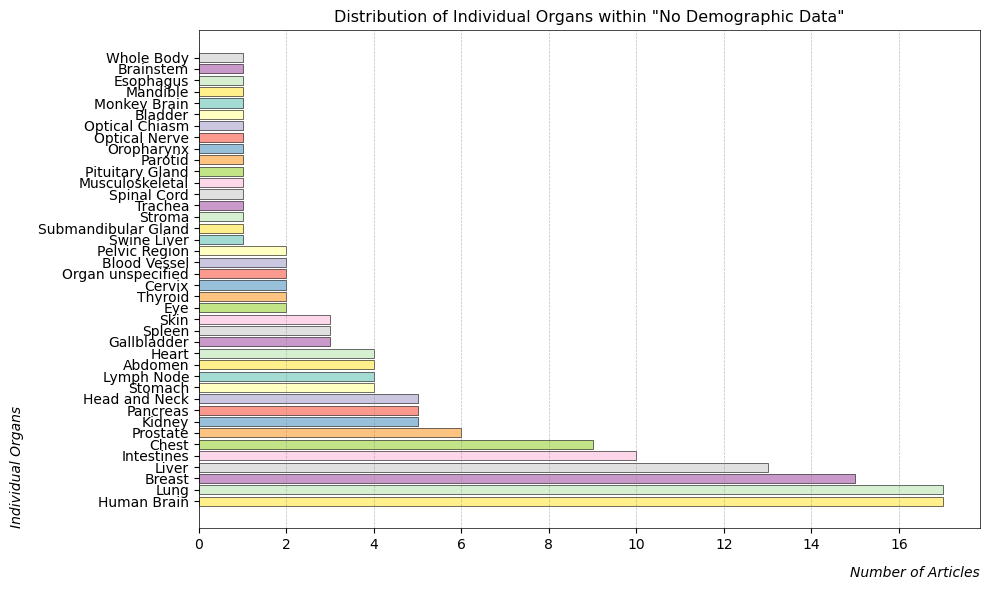

In [41]:
# Group by 'organ_types' (individual organs) and count occurrences for 'No Demographic Data'
# Replace organ names in the DataFrame with standardized names using the mapping
df_expanded['organ_types'] = df_expanded['organ_types'].apply(lambda x: organ_mapping.get(x, x))

# Filter the data for 'No Demographic Data'
no_demo_data = df_expanded[df_expanded['demographics_usage'] == 'No Demographic Data']

# Regroup by 'organ_types' and count occurrences
grouped_no_demo = no_demo_data.groupby('organ_types').size().reset_index(name='Count')

# Sort the DataFrame based on 'Count' to make the plot more readable
grouped_no_demo_sorted = grouped_no_demo.sort_values('Count', ascending=False)
print(len(grouped_no_demo_sorted))

# Plotting the distribution of organs for 'No Demographic Data'
# Converting the counts into percentages
# grouped_no_demo_sorted['Percentage'] = grouped_no_demo_sorted['Count'] / grouped_no_demo_sorted['Count'].sum() * 100
# print(grouped_no_demo_sorted['Percentage'].sum()) checking if the total gives 100%

# Plotting
colors = plt.cm.Set3_r.colors  
plt.figure(figsize=(10,6))  

plt.barh(grouped_no_demo_sorted['organ_types'], grouped_no_demo_sorted['Count'], color=colors, edgecolor='black', linewidth=0.5, alpha=0.8, height=0.8)

plt.title('Distribution of Individual Organs within "No Demographic Data"', fontsize=11.5, loc='center')
#plt.xlabel('Percentage of Articles (%)', fontsize=10, labelpad=10, loc='right', style='italic')
plt.xlabel('Number of Articles', fontsize=10, labelpad=10, loc='right', style='italic')
plt.ylabel('Individual Organs', fontsize=10, labelpad=10, loc='bottom', style='italic')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(axis='x', linestyle='--', which='both', color='gray', alpha=0.5)

#plt.savefig('individual_organs_no_demographic_data.png', dpi=300, bbox_inches='tight', transparent=True)
plt.tight_layout()
plt.show()

Plot saved to 05MICCAI_notebook_data_visualization/individual_organs_no_demographic_data.png


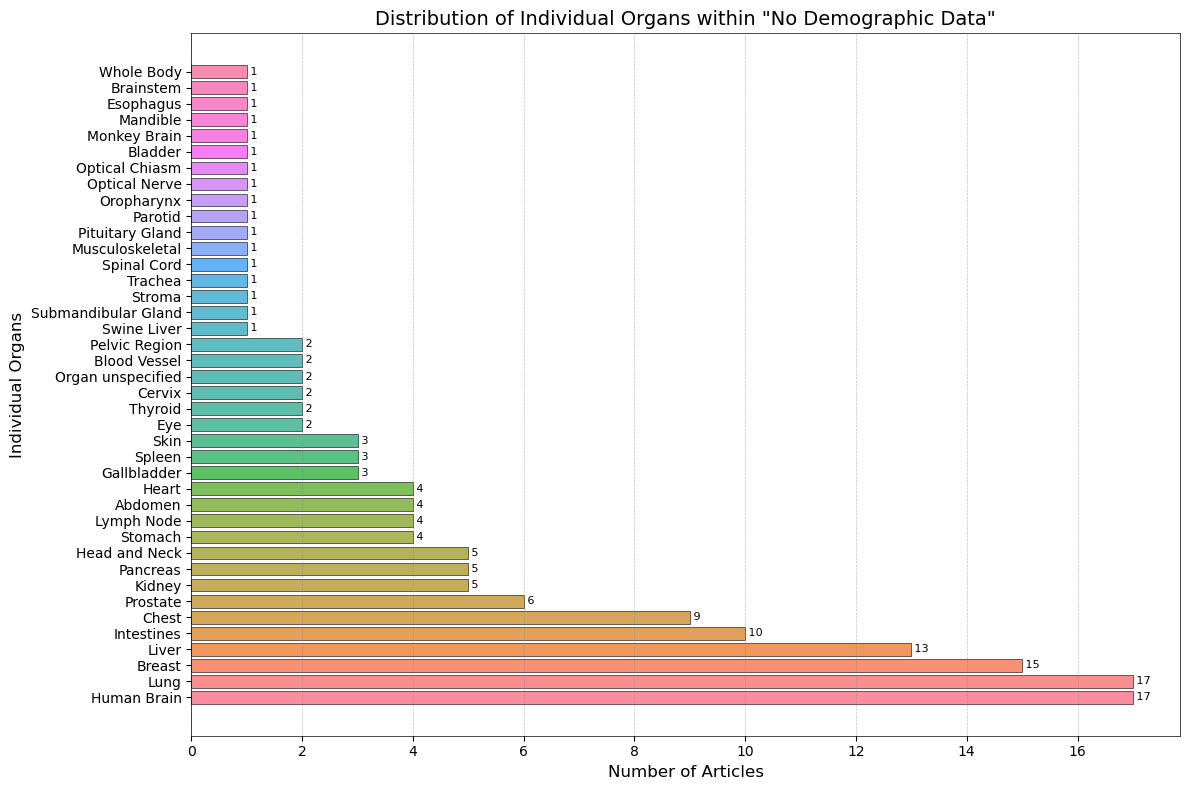

In [42]:
# Set the color palette
palette = sns.color_palette("husl", len(grouped_no_demo_sorted))

# Plotting
plt.figure(figsize=(12, 8))
bars = plt.barh(grouped_no_demo_sorted['organ_types'], grouped_no_demo_sorted['Count'], color=palette, edgecolor='black', linewidth=0.5, alpha=0.8, height=0.8)

# Add value labels to each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f' {int(bar.get_width())}', va='center', ha='left', color='black', fontsize=8)

plt.title('Distribution of Individual Organs within "No Demographic Data"', fontsize=14)
plt.xlabel('Number of Articles', fontsize=12)
plt.ylabel('Individual Organs', fontsize=12)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(axis='x', linestyle='--', which='both', color='gray', alpha=0.5)
save_plot_to_folder(plt, 'individual_organs_no_demographic_data.png') # Save the plot to the plots folder
plt.tight_layout()
plt.show()

***
## Aggregating Categories for Better Readability of Plot
***

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # For better color options
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_organ_distribution_by_demographics(df, organ_column, demo_usage_column, save_path):
    """
    Plots a stacked bar chart of the distribution of organ categories across different demographic usage.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    organ_column (str): The column name for the organ categories.
    demo_usage_column (str): The column name for demographic usage.
    save_path (str): The path to save the plot image.
    """

    # Expand the 'organ_category_refined' to separate rows for each category
    df_expanded = df.drop(organ_column, axis=1).join(df[organ_column].str.split(', ').explode().reset_index(drop=True))

    # Group by 'demographics_usage' and the expanded 'organ_category_refined', then count each group
    grouped = df_expanded.groupby([demo_usage_column, organ_column]).size().reset_index(name='Count')

    # Find the top 5 organ types
    top_organ_types = df_expanded[organ_column].value_counts().head(6).index.tolist()

    # Filter the DataFrame for only the top 5 organ types
    df_top_organ_types = df_expanded[df_expanded[organ_column].isin(top_organ_types)]

    # Group by 'demographic_usage' and the filtered 'organ_column', then count each group
    grouped = df_top_organ_types.groupby([demo_usage_column, organ_column]).size().reset_index(name='Count')

    # Pivot data to get 'organ_column' categories as columns filled with counts
    pivot_df = grouped.pivot_table(index=demo_usage_column, columns=organ_column, values='Count', fill_value=0).sort_values(by=demo_usage_column, ascending=False)

    # Set the color palette using a gradient based on count, matching the previous plot
    colors = sns.color_palette("rocket", n_colors=len(top_organ_types))
    color_dict = {organ: color for organ, color in zip(top_organ_types, colors)}  # Map colors to organ types

    # Plotting the horizontal stacked bar chart
    ax = pivot_df.plot(kind='barh', stacked=True, figsize=(10,5), color=[color_dict.get(organ, '#333333') for organ in pivot_df.columns], 
                       width=0.95, edgecolor='black', linewidth=0.5, alpha=0.8)

    plt.xlabel('Distribution of Main Organ Categories', fontsize=10, labelpad=15, loc='right')
    plt.ylabel('Demographic Usage', fontsize=10, labelpad=15, loc='top')

    #ax.set_yticklabels(['No Use', 'Limited Use', 'Extensive Use'], fontsize=11, rotation=0, va='top')
    #ax.set_yticklabels(['Extensive Use', 'Limited Use', 'No Use'], fontsize=11, rotation=0, va='top')
    ax.set_yticklabels(['None', 'Limited', 'Extensive'], fontsize=11, rotation=90, va='center')

    # Set the x-axis ticks using MultipleLocator
    interval = 10  # Set this to your desired interval
    ax.xaxis.set_major_locator(ticker.MultipleLocator(interval))

    plt.xlim(0, 100)  # Set the x-axis limit to 100 for 100 articles in total
    plt.ylim(-0.5, len(pivot_df.index)-0.5)  # Set the y-axis limit based on the number of demographic usage types

    plt.legend(loc='upper right', fontsize='11.5', shadow=False, fancybox=True, ncol=2, frameon=True, edgecolor='black', 
               framealpha=0.5, borderpad=0.5, labelspacing=0.5, handlelength=1.5, handletextpad=0.5, handleheight=1.5)
    
    plt.grid(axis='x', linestyle='--', which='both', color='gray', alpha=0.5)

    # Remove the frame of the plot
    ax.spines['top'].set_visible(False)  # Remove the top spine
    ax.spines['right'].set_visible(False)  # Remove the right spine
    ax.spines['left'].set_visible(False)  # Remove the left spine
    ax.spines['bottom'].set_visible(True)  # Remove the bottom spine

    # Save and show the plot
    save_plot_to_folder(plt, save_path) # Save the plot to the plots folder
    plt.tight_layout()
    plt.show()

In [44]:

def plot_image_distribution_by_demographics(df, image_column, demo_usage_column, save_path):
    """
    Plots a stacked bar chart of the top 5 image types categories across different demographic usage.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    image_column (str): The column name for the image categories.
    demo_usage_column (str): The column name for demographic usage.
    save_path (str): The path to save the plot image.
    """

    # Expand the 'image_column' to separate rows for each image type
    df_expanded = df.drop(image_column, axis=1).join(df[image_column].str.split(', ').explode().reset_index(drop=True))

    # Find the top 5 image types
    top_image_types = df_expanded[image_column].value_counts().head(6).index.tolist()

    # Filter the DataFrame for only the top 5 image types
    df_top_image_types = df_expanded[df_expanded[image_column].isin(top_image_types)]

    # Group by 'demographic_usage' and the filtered 'image_column', then count each group
    grouped = df_top_image_types.groupby([demo_usage_column, image_column]).size().reset_index(name='Count')

    # Pivot data to get 'image_column' categories as columns filled with counts
    pivot_df = grouped.pivot_table(index=demo_usage_column, columns=image_column, values='Count', fill_value=0).sort_values(by=demo_usage_column, ascending=False)

    # Plotting the horizontal stacked bar chart
    colors = plt.cm.Set2.colors[:len(top_image_types)]  # Adjust color selection for top 5

    ax = pivot_df.plot(kind='barh', stacked=True, figsize=(10, 4), color=colors, width=0.95, edgecolor='black', linewidth=0.2, alpha=0.7)

    plt.xlabel('Distribution of Main Image Types', fontsize=10, labelpad=15, loc='right')
    plt.ylabel('Demographic Usage', fontsize=10, labelpad=15, loc='top')
    #ax.set_yticklabels(['Extensive Use', 'Limited Use', 'No Use'], fontsize=11, rotation=0)
    #ax.set_yticklabels(['No Use', 'Limited Use', 'Extensive Use'], fontsize=11, rotation=0, va='top')
    ax.set_yticklabels(['None', 'Limited', 'Extensive'], fontsize=11, rotation=90, va='center')

    # Set the x-axis ticks using MultipleLocator
    interval = 10  # Set this to your desired interval
    ax.xaxis.set_major_locator(ticker.MultipleLocator(interval))

    plt.xlim(0, 100)  # Set the x-axis limit to 100 for 100 articles in total
    plt.ylim(-0.5, len(pivot_df.index)-0.5)  # Set the y-axis limit based on the number of demographic usage types
    
    plt.legend(fontsize='11.5', loc='upper right', shadow=False, fancybox=True, ncol=1, frameon=True, edgecolor='black', framealpha=0.5, 
               borderpad=0.5, labelspacing=0.5, handlelength=1., handletextpad=0.5, handleheight=1.)
    
    plt.grid(axis='x', linestyle='--', which='both', color='gray', alpha=0.5)
    
    # Remove the frame of the plot
    ax.spines['top'].set_visible(False)  # Remove the top spine
    ax.spines['right'].set_visible(False)  # Remove the right spine
    ax.spines['left'].set_visible(False)  # Remove the left spine
    ax.spines['bottom'].set_visible(True)  # Remove the bottom spine

    # Save and show the plot
    save_plot_to_folder(plt, save_path)  # Save the plot to the plots folder
    plt.tight_layout()
    plt.show()

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

def reclassify_locations(df, location_column):
    """
    Reclassify the location categories into four broad categories.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    location_column (str): The column name for the location categories.

    Returns:
    DataFrame: The DataFrame with updated location categories.
    """
    # Define your classification logic
    healthcare_facilities = ['Healthcare facility']  # Replace with actual healthcare location identifiers
    geographical_entities = ['Large-scale geographical entity', 'Subnational geographical entity']  # Replace with actual geographical location identifiers
    no_location_info = 'No Location information'

    # Apply classification
    df['Reclassified_Location'] = df[location_column].apply(
        lambda x: 'Healthcare facilities' if x in healthcare_facilities 
        else ('Geographical entities' if x in geographical_entities
              else ('No Location information' if x == no_location_info
                    else 'Other locations'))
    )

    return df

def plot_location_distribution_by_demographics(df, demo_column, location_column, save_path):
    """
    Plots a stacked bar chart of the distribution of reclassified location categories across different demographic usages.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    demo_column (str): The column name for the demographic usages.
    location_column (str): The column name for the location categories.
    save_path (str): The path to save the plot image.
    """
    # Reclassify locations
    df = reclassify_locations(df, location_column)

    # Colors for the plot
    #colors = plt.cm.tab10.colors[:len(df['Reclassified_Location'].unique())]

    # Group by 'Demographic' and 'Reclassified_Location', then count each group
    grouped = df.groupby([demo_column, 'Reclassified_Location']).size().reset_index(name='Count')

    # Pivot data to get 'Reclassified_Location' categories as columns filled with counts
    pivot_df = grouped.pivot_table(index=demo_column, columns='Reclassified_Location', values='Count', fill_value=0).sort_values(by=demo_column, ascending=False)

    # Plotting
    #ax = pivot_df.plot(kind='barh', stacked=True, figsize=(10, 4), color=colors, width=0.95, edgecolor='black', linewidth=0.2, alpha=0.7)

    # Set the color palette using a gradient based on count, matching the previous plot
    colors = sns.color_palette("Spectral_r",n_colors=len(df['Reclassified_Location'].unique()))
    color_dict = {location: color for location, color in zip(df['Reclassified_Location'].unique(), colors)}  # Map colors to location types

    # Plotting the horizontal stacked bar chart
    ax = pivot_df.plot(kind='barh', stacked=True, figsize=(10, 4), color=[color_dict.get(location, '#333333') for location in pivot_df.columns], width=0.95, 
                       edgecolor='black', linewidth=0.2, alpha=0.7)

    plt.xlabel('Distribution of Datasets Sources', fontsize=10, labelpad=15, loc='right')
    plt.ylabel('Demographic Usage', fontsize=10, labelpad=15, loc='top')

    #ax.set_yticklabels(['Extensive Use', 'Limited Use', 'No Use'], fontsize=11, rotation=0)
    #ax.set_yticklabels(['No Use', 'Limited Use', 'Extensive Use'], fontsize=11, rotation=0, va='top')
    ax.set_yticklabels(['None', 'Limited', 'Extensive'], fontsize=11, rotation=90, va='center')

    # Set the x-axis ticks using MultipleLocator
    interval = 10  # Set this to your desired interval
    ax.xaxis.set_major_locator(ticker.MultipleLocator(interval))

    plt.xlim(0, 100)  # Set the x-axis limit to 100 for 100 articles in total
    plt.ylim(-0.5, len(pivot_df.index)-0.5)  # Set the y-axis limit based on the number of demographic usage types
    
    plt.legend(loc='upper right', fontsize='11.5', title_fontsize='small', shadow=False, fancybox=True, ncol=1, frameon=True, edgecolor='black', 
               framealpha=0.5, borderpad=0.5,labelspacing=0.5, handlelength=1., handletextpad=0.5, handleheight=1.)
    
    plt.grid(axis='x', linestyle='--', which='both', color='gray', alpha=0.5)
    
    # Remove the frame of the plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(True)

    # Save and show the plot
    save_plot_to_folder(plt, save_path) # Save the plot to the plots folder
    plt.tight_layout()
    plt.show()

In [46]:
def reclassify_dataset_quantities(df, dataset_column):
    """
    Reclassify the dataset quantities into three broad categories: '1', '2-3', and '4+' datasets.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    dataset_column (str): The column name for the dataset quantity.

    Returns:
    DataFrame: The DataFrame with updated dataset quantity categories.
    """
    # Define the classification logic
    def classify_quantity(x):
        if x == 1:
            return '1 Dataset'
        elif 2 <= x <= 3:
            return '2-3 Datasets'
        else:
            return '4+ Datasets'

    # Apply the classification
    df['Categorized_Datasets'] = df[dataset_column].apply(classify_quantity)
    return df

def plot_dataset_quantity_by_demographics(df, demo_column, dataset_column, save_path):
    """
    Plots a bar chart showing the distribution of the number of datasets used by papers, categorized by demographics usage.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    demo_column (str): The column name for demographic usages.
    dataset_column (str): The column name for dataset quantity.
    save_path (str): The path to save the plot image.
    """
    # Reclassify dataset quantities
    df = reclassify_dataset_quantities(df, dataset_column)

    # Colors for the plot
    colors = plt.cm.tab20c_r.colors[5:]  # Adjust colors for the 3 new categories

    # Group by demographic usage and reclassified dataset quantities, then count each group
    grouped = df.groupby([demo_column, 'Categorized_Datasets']).size().reset_index(name='Count')

    # Pivot data to get reclassified dataset quantities as columns filled with counts
    pivot_df = grouped.pivot_table(index=demo_column, columns='Categorized_Datasets', values='Count', fill_value=0)

    # Plotting
    ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 8), color=colors, width=0.95, edgecolor='black', linewidth=0.5, alpha=0.9)

    # Set the plot labels and legend
    plt.xlabel('Demographic Usage', fontsize=12, labelpad=15, loc='right', style='italic')
    plt.ylabel('Distribution of Datasets', fontsize=12, labelpad=15, loc='top', style='italic')
    
    # Set the x-axis tick labels to the demographic categories
    ax.set_xticklabels(['Extensive Use', 'Limited Use', 'No Use'], fontsize=11, rotation=0)
    
    # Set x-axis limits to fit all categories
    plt.xlim(-0.49, len(pivot_df.index)-0.49)
    
    plt.legend(title="Dataset Distribution", loc='upper left', fontsize='11.5', shadow=False, fancybox=True, ncol=1, frameon=True, edgecolor='black', framealpha=1, borderpad=0.5,
               labelspacing=0.5, handlelength=1.5, handletextpad=0.5, handleheight=1.5)
    
    plt.grid(axis='x', linestyle='--', which='both', color='gray', alpha=0.5)
    
    #plt.savefig(save_path, dpi=300, bbox_inches='tight', transparent=True)
    save_plot_to_folder(plt, save_path) # Save the plot to the plots folder
    plt.show()

In [47]:
filename = '05MICCAI_notebook_preprocessed_annotation_data.csv'

df1 = pd.read_csv(filename)

Plot saved to 05MICCAI_notebook_data_visualization/organs_by_demographics_reclassified.png


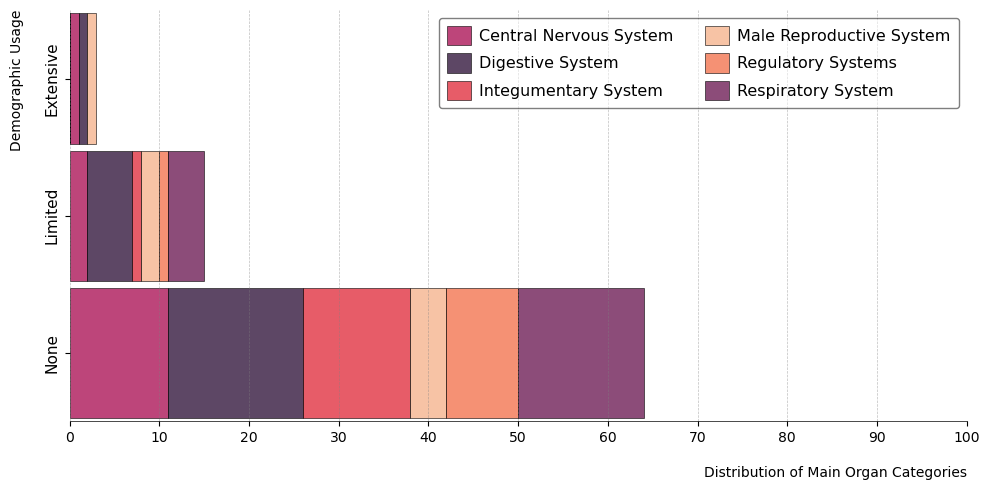

Plot saved to 05MICCAI_notebook_data_visualization/image_types_by_demographics_reclassified.png


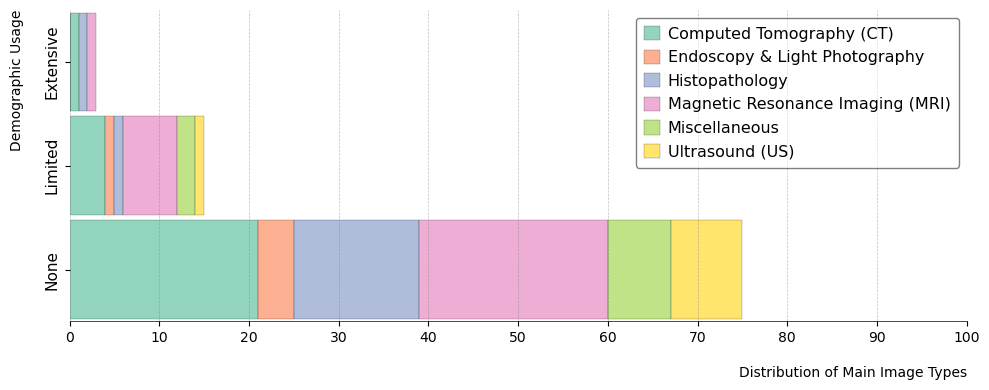

Plot saved to 05MICCAI_notebook_data_visualization/location_types_by_demographics_reclassified.png


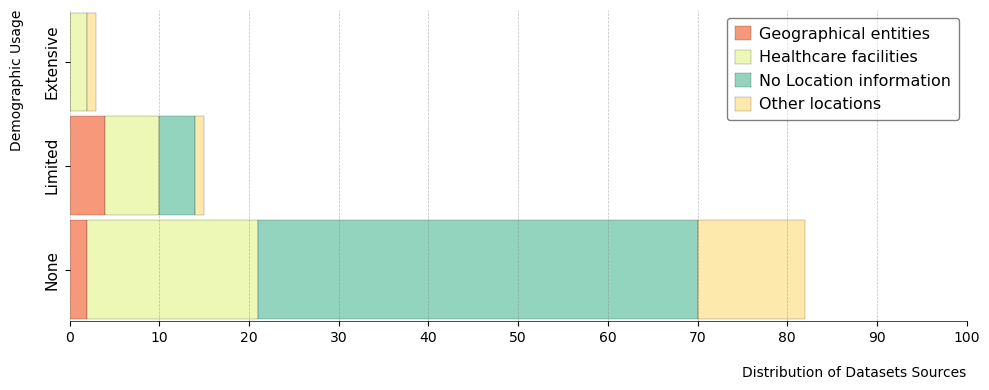

'Aggrate the dataset quantities into 3 categories: 1, 2-3, 4+ datasets'

In [48]:
# Organ categories
'''Aggregate the organ categories into 5 categories based on top 5 organ categories'''
plot_organ_distribution_by_demographics(df1, 'organ_category_refined', 'demographics_usage', 'organs_by_demographics_reclassified.png')

# Image types
'''Plot top 5 Image Types'''
plot_image_distribution_by_demographics(df1, 'image_category', 'demographics_usage', 'image_types_by_demographics_reclassified.png')

# Location categories
'''Aggregate the location categories into 4 categories: 
1. Healthcare facilities
2. Other locations
3. Geographical entities
4. No Location information'''
plot_location_distribution_by_demographics(df1, 'demographics_usage', 'location_category', 'location_types_by_demographics_reclassified.png')

# Quantities of datasets
'''Aggrate the dataset quantities into 3 categories: 1, 2-3, 4+ datasets'''
# plot_dataset_quantity_by_demographics(df1, 'demographics_usage', 'dataset quantity', 'dataset_quantity_by_demographics_reclassified.png')

### Plotting the organ distribution for 'No Demographic Data' from the reclassified data
***


Plot saved to 05MICCAI_notebook_data_visualization/top_dist_individual_organs_no_demographic_data.png


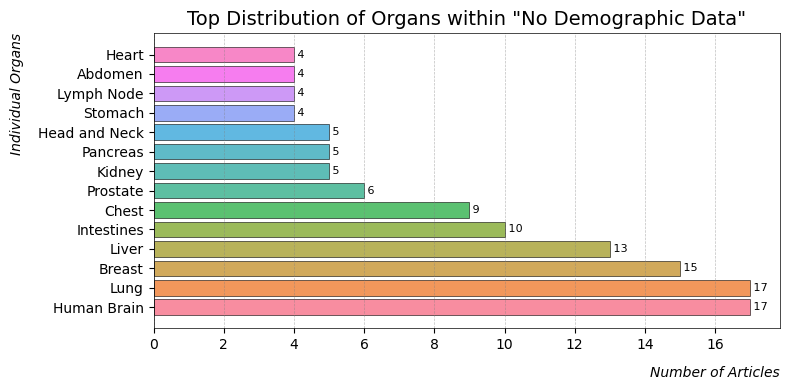

In [49]:
# Plotting the individual organs distribution for 'No Demographic Data' from the reclassified data

# Let's filter for the top 5 organs first
top_organs_dist = grouped_no_demo_sorted.nlargest(14, 'Count')
#print(f'Total articles:\n{len(grouped_no_demo_sorted)}') # Checking if the total number of articles matches the number of articles within 'No Demographic Data'

# Set the color palette for the top 5
palette = sns.color_palette("husl", len(top_organs_dist))

# Plotting
plt.figure(figsize=(8, 4))
bars = plt.barh(top_organs_dist['organ_types'], top_organs_dist['Count'], color=palette, edgecolor='black', linewidth=0.5, alpha=0.8, height=0.8)

# Add value labels to each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f' {int(bar.get_width())}', va='center', ha='left', color='black', fontsize=8)

plt.title('Top Distribution of Organs within "No Demographic Data"', fontsize=14)
plt.xlabel('Number of Articles', fontsize=10, labelpad=10, loc='right', style='italic')
plt.ylabel('Individual Organs', fontsize=10, labelpad=10, loc='top', style='italic')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(axis='x', linestyle='--', which='both', color='gray', alpha=0.5)

plt.tight_layout()

save_plot_to_folder(plt, 'top_dist_individual_organs_no_demographic_data.png') # Save the plot to the plots folder
plt.show()

Plot saved to 05MICCAI_notebook_data_visualization/top_dist_individual_organs_no_demographic_data_improved.png


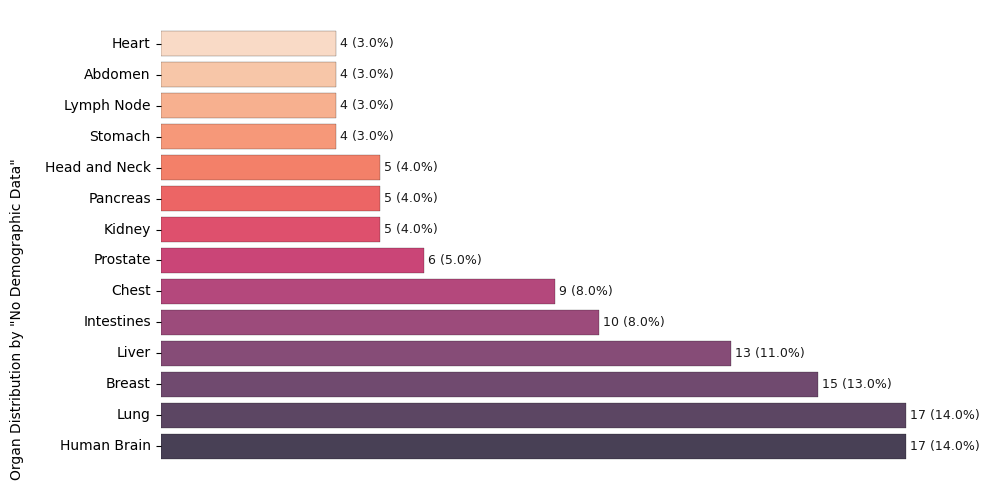

In [50]:
# Filter for top distribution of organs first
top_dist_organs_percentage = grouped_no_demo_sorted.nlargest(14, 'Count')

# Calculate percentage of total for annotation
total_count = top_dist_organs_percentage['Count'].sum()
top_dist_organs_percentage['Percentage'] = (top_dist_organs_percentage['Count'] / total_count * 100).round(0)

# Set the color palette using a gradient based on count
colors = sns.color_palette("rocket", n_colors=len(top_dist_organs_percentage))

# Plotting
plt.figure(figsize=(10, 5))
bars = plt.barh(top_dist_organs_percentage['organ_types'], top_dist_organs_percentage['Count'], color=colors, edgecolor='black', linewidth=0.2, 
                alpha=0.8, height=0.8)

# Add value labels to each bar
for bar, pct in zip(bars, top_dist_organs_percentage['Percentage']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f' {int(bar.get_width())} ({pct}%)', va='center', ha='left', color='black', fontsize=9, 
            rotation=0, alpha=0.9, zorder=5)

#plt.title('Top Organ Distribution within "No Demographic Data"', fontsize=16)
plt.ylabel('Organ Distribution by "No Demographic Data"', fontsize=10, labelpad=15, loc='bottom')
plt.xlabel('', fontsize=10, labelpad=10, loc='right', style='italic').set_visible(False)

#plt.xticks(fontsize=10)
plt.xticks([])
plt.yticks(fontsize=10, va='center')

plt.grid(axis='x', linestyle='--', which='both', color='gray', alpha=0.5)

# Remove the frame of the plot
ax = plt.gca()  # Get current axis
ax.spines['top'].set_visible(False)  # Remove the top spine
ax.spines['right'].set_visible(False)  # Remove the right spine
ax.spines['left'].set_visible(False)  # Remove the left spine
ax.spines['bottom'].set_visible(False)  # Remove the bottom spine

# # Adding a legend for organ types
# ax.legend(handles=[plt.Rectangle((0,0),1,1, color=color, ec="k") for color in colors], labels=top_dist_organs_percentage['organ_types'].tolist(), 
#             title="Organ Types",  loc='upper right', fontsize='11', shadow=False, 
#             fancybox=True, ncol=2, frameon=True, edgecolor='black', framealpha=0.5, borderpad=0.5, labelspacing=0.5, 
#             handlelength=1.5, handletextpad=0.5, handleheight=1.5)


plt.tight_layout()
save_plot_to_folder(plt, 'top_dist_individual_organs_no_demographic_data_improved.png') # Save the plot to the plots folder
plt.show()

Plot saved to 05MICCAI_notebook_data_visualization/organ_dataset_distribution.png


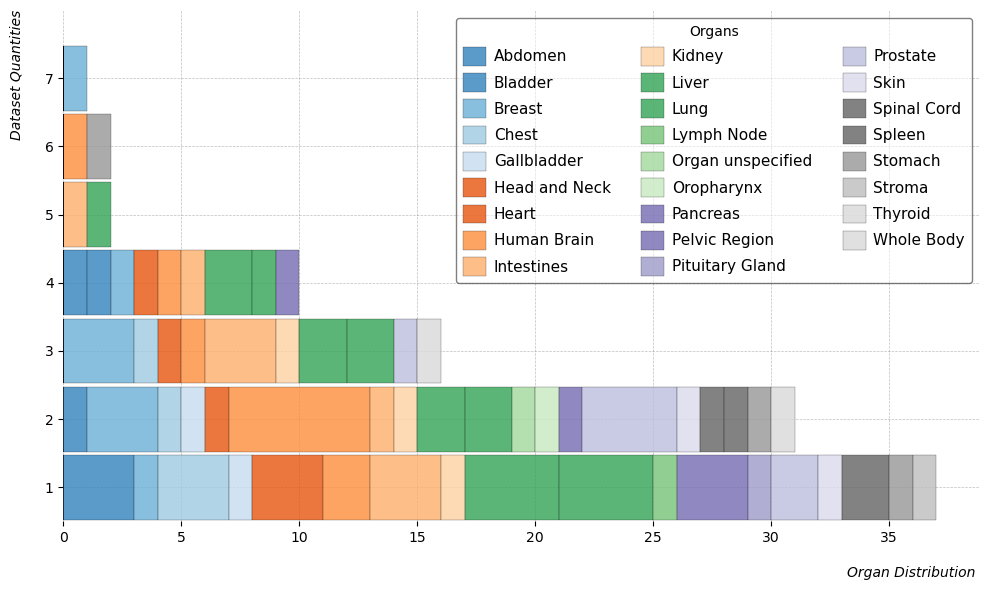

In [51]:
# Read the cleaned annotation data
df1 = pd.read_csv(filename)

def plot_dataset_quantity_by_organs(df, organ_column,dataset_column, save_path, organ_replacements=organ_mapping):
    """
    Plots a bar chart showing the distribution of the number of datasets used by papers, categorized by organs.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    organ_column (str): The column name for organ types.
    dataset_column (str): The column name for dataset quantity.
    save_path (str): The path to save the plot image.
    """
   
    df_expanded = df.drop(organ_column, axis=1).join(df[organ_column].str.split(', ').explode().reset_index(drop=True))

    df_expanded[organ_column] = df_expanded[organ_column].apply(lambda x: organ_mapping.get(x, x))

    # Group dataset quantities by individual organ usage
    # df1[organ_column] = df1[organ_column].str.strip('[]').str.replace("'", "").str.split(', ')
    #df_expanded = df1.explode(organ_column)

    # Explode the organ_column so each organ type is in its own row
    #df_exploded = df.explode(organ_column)

    # Group by organ and dataset quantity, then count each group
    grouped = df_expanded.groupby([organ_column, dataset_column]).size().reset_index(name='Count')

    # Pivot data to get organ types as rows and dataset quantities as columns
    pivot_df = grouped.pivot_table(index= dataset_column, columns=organ_column, values='Count', fill_value=0)
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = plt.cm.tab20c(np.linspace(0, 1, pivot_df.shape[1]))
    pivot_df.plot(kind='barh', stacked=True, ax=ax, color=colors, width=0.95, edgecolor='black', linewidth=0.2, alpha=0.8)
    
    plt.xlabel('Organ Distribution ', fontsize=10, labelpad=15, loc='right', style='italic')
    plt.ylabel('Dataset Quantities', fontsize=10, labelpad=15, loc='top', style='italic')
    
    # Dynamic dataset labels
    # dataset_labels = [f'{i} Dataset' if i == 1 else f'{i} Datasets' for i in sorted(pivot_df.columns)]
    # plt.legend(title="Number of Datasets", labels=dataset_labels, loc='upper left', fontsize='11.5')

    plt.legend(title="Organs", loc='upper right', fontsize='11', ncol=3,
               shadow=False, fancybox=True, frameon=True, edgecolor='black', framealpha=0.5, borderpad=0.5, 
               labelspacing=0.5, handlelength=1.5, handletextpad=0.5, handleheight=1.5)
    
    plt.ylim(0.5, 8.)

    # Adding grid lines
    ax.grid(True, linestyle='--', which='both', color='gray', alpha=0.5)
    # Remove the frame of the plot
    ax = plt.gca()  # Get current axis
    ax.spines['top'].set_visible(False)  # Remove the top spine
    ax.spines['right'].set_visible(False)  # Remove the right spine
    ax.spines['left'].set_visible(False)  # Remove the left spine
    ax.spines['bottom'].set_visible(False)  # Remove the bottom spine
    ax.set_axisbelow(True)
    
    save_plot_to_folder(plt, save_path) # Save the plot to the plots folder
    plt.tight_layout()
   
    plt.show()

# Usage of the function for dataset quantity analysis by individual organs
plot_dataset_quantity_by_organs(df1, 'organ/body part in datasets', 'dataset quantity', 'organ_dataset_distribution.png')

Plot saved to 05MICCAI_notebook_data_visualization/organ_category_dataset_distribution.png


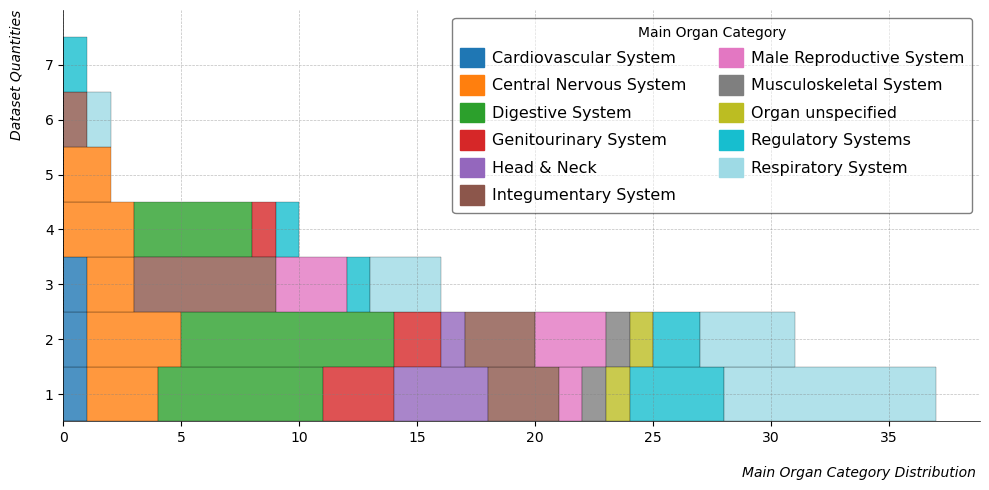

In [52]:
def plot_dataset_quantity_by_organs(df, organ_column, dataset_column, save_path):
    df_expanded = df.drop(organ_column, axis=1).join(df[organ_column].str.split(', ').explode().reset_index(drop=True))
    df_expanded[organ_column] = df_expanded[organ_column].apply(lambda x: organ_mapping.get(x, x))

    # Sort the DataFrame by organ categories to maintain a consistent order
    df_expanded.sort_values(by=organ_column, inplace=True)

    # Group by organ and dataset quantity, then count each group
    grouped = df_expanded.groupby([organ_column, dataset_column]).size().reset_index(name='Count')
    pivot_df = grouped.pivot_table(index=dataset_column, columns=organ_column, values='Count', fill_value=0)

    # Assign colors to categories based on a consistent and sorted order
    categories = pivot_df.columns.tolist()
    colors = plt.cm.tab20(np.linspace(0, 1, len(categories)))

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 5))
    pivot_df.plot(kind='barh', stacked=True, ax=ax, color=colors, width=1, edgecolor='black', linewidth=0.2, alpha=0.8)

    plt.xlabel('Main Organ Category Distribution ', fontsize=10, labelpad=15, loc='right', style='italic')
    plt.ylabel('Dataset Quantities', fontsize=10, labelpad=15, loc='top', style='italic')

    # Create legend with sorted categories
    handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(categories))]
    plt.legend(handles, categories, title="Main Organ Category", loc='upper right', fontsize='11.5', ncol=2,
               shadow=False, fancybox=True, frameon=True, edgecolor='black', framealpha=0.5, borderpad=0.5,
               labelspacing=0.5, handlelength=1.5, handletextpad=0.5, handleheight=1.5)

    plt.ylim(0.5, 8.)  # Set the y-axis limits from 0.5 to exclude dataset quantity == 0

    ax.grid(True, linestyle='--', which='both', color='gray', alpha=0.5)

    # Remove the frame of the plot
    ax = plt.gca()  # Get current axis
    ax.spines['top'].set_visible(False)  # Remove the top spine
    ax.spines['right'].set_visible(False)  # Remove the right spine
    ax.spines['left'].set_linewidth(0.5)  # Set the left spine linewidth to 0.5
    ax.spines['bottom'].set_linewidth(0.5)  # Set the bottom spine linewidth to 0.5


    plt.tight_layout()
    save_plot_to_folder(plt, save_path) # Save the plot to the plots folder
    plt.show()

plot_dataset_quantity_by_organs(df1, 'organ_category_refined', 'dataset quantity', 'organ_category_dataset_distribution.png')


## Dataset Names and Usage in Selected MICCAI 2023 Articles
***

This section of the notebook analyses the datasets, which names has been provided by the articles.

In [53]:
# Load the Excel file
file_path = '../annotation_data/annotation_data_raw.xlsx'

# Read the sheet containing annotations of dataset names into a separate DataFrame
df1 = pd.read_excel(file_path, sheet_name='annotation_notes').fillna('None')
print('The  Number of Unique Articles:', len(df1['title'].unique()))

df1.head()
df1['name of dataset'] = df1['name of dataset'].str.lower()
unique_datasets = df1['name of dataset'].unique() 
print('The Number of Unique Datasets:', len(unique_datasets))

The  Number of Unique Articles: 100
The Number of Unique Datasets: 66


In [54]:
# Mapping dictionary: map variant names to a standardized name of datasets
name_mapping = {
    "Name of Dataset not Provided": "None",
    "PANDAS Dataset":  ['panda challenge dataset'],
    "PCa-AS Dataset": ['pca-as'], 
    "PCa-BT Dataset": ['pca-bt'], 
    "Lyon19 Challenge Dataset": ["lyon19 challenge dataset"],
    "NUCLICK Training Dataset": ["nuclick training dataset"],
    "CAMUS Dataset": ["camus dataset"],
    "JSRT Dataset": ["jsrt dataset", "the japanese society of radiological technology dataset"],
    "GVBLEED Dataset": ["gvbleed dataset"],
    "TNBN Dataset": ["tnbn dataset"],
    "KIRC Dataset": ["kirc dataset"],
    "CRC Dataset": ["crc dataset"],
    "LLD Dataset": ["lld study"],
    "DM Dataset": ["dm study"],
    "ADNI Dataset": ["alzheimer’s disease neuroimaging initiative (adni) dataset", "adni dataset", "adni"],
    "HMSS Dataset": ["hmss dataset"],
    "BUSI Dataset": ["busi dataset"],
    "BUSIS Dataset": ["busis dataset"],
    "Dataset B": ["dataset b"],
    "NSCLC-TCIA Dataset": ["nsclc-tcia dataset", "nsclc radiomics and nsclc radiogenomics"],
    "Montgomery Dataset": ["montgomery dataset"],
    "Shenzen Dataset": ["shenzen dataset"],
    "ISIC 2018 Dataset": ["isic 2018 dataset"],
    "CVC-ClinicDB Dataset": ["cvc-clinicdb dataset"],
    "OASIS-1 Dataset": ["oasis-1 dataset"],
    "BraTS Dataset 2021": ["2021 brats",  "brats 2021 dataset"],
    "BraTS Dataset 2020": ["2020 brats", "brats 2020 dataset"],
    "BraTS Dataset": ["brats dataset", "brats", "brain tumor segmentation challenge dataset"],
    "BraTS Dataset 2017": ["2017 brats", "brats 2017 dataset", "brain tumor segmentation challenge 2017 (brats) dataset"],
    "BraTS-Reg 2022 Dataset": ["brats-reg 2022 dataset"],
    "LIDC-IDRI Dataset": ["lidc-idri dataset"],
    "TCGA Dataset": ["tcga dataset", "the caner genome atlas (tcga)", "the cancer genome atlas (tcga)"],
    "Human Connectome Project": ["human connectome project", "hcp", "human connectome project (hcp) dataset"],
    "NIH ChestXray-8 Dataset": ["nih chestxray-8 (cxr8) dataset", "chestx-ray8 dataset", "chestxray8 dataset"],
    "NIH ChestXray-14 Dataset": ["nih chestxray-14 (cxr14) dataset", "chestx-ray14 dataset", "chestxray14 dataset"],
    "ChestXR Dataset": ["chestxr dataset"],
    "NLST Dataset": ["nlst dataset"],
    "LiTS Dataset": ["lits dataset"],
    "KiTS Dataset": ["kits dataset"],
    "QUBIQ 2020 Dataset": ["qubiq 2020 dataset"],
    "Breast-MRINACT-Pilot Dataset": ["breast-mrinact-pilot dataset"],
    "GBC US Dataset": ["gbc us dataset"],
    "Kvasir-SEG Dataset": ["kvasir-seg dataset"],
    "PolypGen Dataset": ["polypgen dataset"],
    "DLIVER Dataset": ["dliver dataset"],
    "DLUNG Dataset": ["dlung dataset"],
    "MSD Spleen Dataset": ["msd spleen dataset"],
    "AutoPET Dataset": ["autopet dataset"],
    "ABDOMEN-1K Dataset": ["abdomen-1k dataset"],
    "ABD-110 Dataset": ["abd-110 dataset"],
    "THORAX-85 Dataset": ["thorax-85 dataset"],
    "HaN Dataset": ["han dataset"],
    "CBIS-DDSM Dataset": ["cbis-ddsm dataset"],
    "INbreast Dataset": ["inbreast dataset"],
    "Eye Gaze Dataset": ["eye gaze dataset"],
    "Brain Genomics Superstruct Project": ["brain genomics superstruct project (gsp)", "gsp dataset"],
    "CD-ITB Dataset": ["cd-itb dataset"],
    "Camelyon16 Dataset": ["camelyon16 dataset"],
    "Camelyon17 Dataset": ["camelyon17 dataset"],
    "Camelyon Dataset": ["camelyon dataset", "grand challenge camelyon dataset"],
    "AIDA Dataset": ["aida brln dataset"],
    "DeepLesion Dataset": ["deeplesion dataset"],
    "ISLES Dataset": ["isles dataset", "ischemic stroke lesion segmentation challenge 2015 (isles) dataset"],
    "VINDR-CXR Dataset": ["vindr-cxr dataset"],
    "HECKTOR 2022 Dataset": ["hecktor 2022 dataset"],
    "DECATH-Pancreas Dataset": ["decath-pancreas dataset"],
    "Colored MNIST Dataset": ["colored mnist dataset", "colered mnist dataset",],
    "MNIST Dataset": ["mnist dataset"],
    "HER2 Dataset": ["her2 dataset"],
    "MIMIC-CXR Dataset": ["mimic-cxr dataset"],
    "COVID-19 Segmentation Benchmark": ["covid-19 segmentation benchmark"],
    "ChestMNIST Dataset": ["chestmnist dataset"],
    "DERMAMNIST Dataset": ["dermamnist dataset"],
    "MEDMNISTv2 Dataset": ["medmnistv2 dataset"],
    "Jerry Dataset": ["jerry dataset"],
    "COFFBEE Dataset": ["coffbee dataset"],
    "GOLD ATLAS Dataset": ["gold atlas dataset", "gold atlas - male pelvis - gentle radiotherapy dataset"],
    "RESECT Dataset": ["resect dataset", "resect (retro-spective evaluation of cerebral tumors) dataset", "cerebral tumors (resect) miccai challenge dataset"],
    "Learn2Reg Challenge Dataset": ["learn2reg challenge dataset "],
    "TCGA-NSCLC": ["tcga-nsclc dataset"], 
    "HaN-SEG Dataset": ["han-seg dataset"],
    "REFUGE Dataset": ["refuge dataset"],
    "PDDCA Dataset": ["pddca dataset"],
    "SPARE Dataset": ["spare varian dataset"],
    "ABIDE Dataset": ["abide dataset"],
    "ADHD Dataset": ["adhd dataset"],
    "IXI Dataset": ["ixi dataset"],
    "Mindboggle Dataset": ["mindboggle dataset"],
    "Buckner Dataset": ["buckner dataset"],
    "LPBA Dataset": ["lpba dataset"],
    "GSP Dataset": ["gsp dataset", "brain genomics superstruct project (gsp) dataset"],
    "LUNGx Challenge Dataset": ["lungx challenge dataset"],
    "ACDC Dataset": ["acdc dataset", "aapm low dose ct grand challenge abdominal dataset"],
    "M&Ms Dataset": ["m&ms dataset", "m&ms1-2 dataset"],
    "CMRxMotion Dataset": ["cmrxmotion dataset"],
    "CONSEP1 Dataset": ["consep1 dataset"],
    "BRCA-M2C2 Dataset": ["brca-m2c2 dataset"],
    "LIZARD3 Dataset": ["lizard3 dataset"],
    "Ex Vivo Monkey DMRI Dataset": ["ex vivo monkey dmri dataset"],
    "In Vivo Human Brain MTE Dataset": ["in vivo human brain mte dataset"],
    "FastMRI+ Dataset": ["fastmri+ dataset"],
    "ATLAS v2.0 Dataset": ["atlas v2.0 dataset"],
    "KiTS19 Dataset": ["kits19 dataset"],
    "KiTS21 Dataset": ["kits21 dataset"],
    "PNEN Dataset": ["pnen dataset"],
    "BreakHis Dataset": ["breakhis dataset"],
    "MSSEG Dataset": ["msseg dataset"],
    "Skin3D Dataset": ["skin3d dataset"],
    "TCGA-BRCA Dataset": ["tcga-brca dataset"],
    "Mayo Clinic Low-Dose CT Grand Challenge Dataset": ["mayo-clinic low-dose ct grand challenge dataset"],
    "RIDER Dataset": ["rider dataset"],
    "PatchGastric Stomach Tumor Pathological Image Dataset": ["patchgastric stomach tumor pathological image dataset"],
    "MSKUS Dataset": ["mskus dataset"],
    "Gaze Dataset": ["gaze dataset"],
    "Easy-RESECT Dataset": ["easy-resect (retrospective evaluation of cerebral tumors) dataset"],
    "ISPY-1 Dataset": ["ispy-1 dataset"],
    "Intra Dataset": ["intra dataset"],
    "TCIA Dataset": ["the cancer imaging archive (tcia)"],
}

In [55]:
# Function to normalize and map dataset names
def normalize_datasets(datasets, mapping):
    standardized_datasets = []
    for entry in datasets:
        # Split the entry if it contains multiple datasets
        sub_entries = map(str.strip, entry.split(','))
        for sub in sub_entries:
            normalized = None
            # Check each mapped name to find a match
            for standard, variants in mapping.items():
                if any(var.lower() in sub.lower() for var in variants):
                    normalized = standard
                    break
            if normalized:
                standardized_datasets.append(normalized)
            else:
                standardized_datasets.append(sub)  # Keep original if no match found
    return standardized_datasets

# Apply normalization
normalized_list = normalize_datasets(unique_datasets, name_mapping)
print('Number of unique datasets:', len(normalized_list))
print('Number of unique standardized datasets:', len(set(normalized_list)))
def categorize_datasets(dataframe):    
    # Split the row by comma and strip spaces
    dataset_names = [x.strip() for x in dataframe.split(',')]
    # Initialize a set to hold unique categories for this row
    row_categories = set()
    for name in dataset_names:
        # Check each category for a match and add to the set
        for category, types in name_mapping.items():
            if name in types:
                row_categories.add(category)
                break
    # Return a comma-separated string of unique categories or a single category
    return ', '.join(row_categories) if row_categories else 'Name of Dataset not Provided'


df1['normalized_datasets'] = df1['name of dataset'].apply(categorize_datasets)
df1.to_csv(notebook_name + 'normalized_datasets.csv', index=False)
dataset_counts = df1['normalized_datasets'].str.split(',').explode().str.strip().value_counts()


unique_datasets = dataset_counts.index.tolist()
unique_datasets_df = pd.DataFrame(unique_datasets, columns=['datasets'])

unique_datasets_df['count'] = dataset_counts.values
most_used_datasets = unique_datasets_df.nlargest(10, 'count')
unique_datasets_df['percentage'] = (dataset_counts.values / dataset_counts.sum()) * 100
unique_datasets_df['percentage'] = unique_datasets_df['percentage'].round(2)

def write_dataset_details(df):
    unique_datasets_df['count'] = dataset_counts.values
    most_used_datasets = unique_datasets_df.nlargest(10, 'count')
    unique_datasets_df['percentage'] = (dataset_counts.values / dataset_counts.sum()) * 100
    unique_datasets_df['percentage'] = unique_datasets_df['percentage'].round(2)

    # Create the output directory if it does not exist
    output_dir = '05MICCAI_notebook_summary_statistics/'
    os.makedirs(output_dir, exist_ok=True)

    output_file = os.path.join(output_dir, notebook_name + 'dataset_details.txt')
    with open(output_file, 'w') as file:
        file.write('Dataset Summary Statistics\n')
        file.write('==========================\n')
     
        file.write(f'Total number of unique datasets: {len(unique_datasets_df)}\n')
        file.write(f'Total number of unique standardized datasets: {len(set(normalized_list))}\n')
        file.write(f'Top 10 Datasets\n')
        file.write('================\n')
        file.write('Dataset: Count (Percentage) by Article\n')
        for index, row in most_used_datasets.iterrows():
            file.write(f'{row["datasets"]}: {row["count"]} ({row["percentage"]}%)\n')
        file.write('\n')
        
write_dataset_details(unique_datasets_df)        
unique_datasets_df.to_csv(notebook_name + 'dataset_counts.csv', index=False)

Number of unique datasets: 162
Number of unique standardized datasets: 8


## Plotly
***

In [56]:
filename = '05MICCAI_notebook_preprocessed_annotation_data.csv'

df1 = pd.read_csv(filename)

In [57]:
def install_kaleido():
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'kaleido'])

def check_kaleido_installed():
    try:
        import kaleido
    except ImportError:
        print("Kaleido is not installed. Installing now...")
        install_kaleido()

def prepare_and_plot_sankey_dataset_disclosure(file_path, output_filename, output_format='png'):
    # Load data
    data = pd.read_csv(file_path)
    
    # Select relevant columns and handle missing values
    sankey_data = data[['dataset_disclosure_category', 'demographics_usage']].fillna('Unknown')
    sankey_data['dataset_disclosure_category'] = sankey_data['dataset_disclosure_category'].str.split(', ')
    sankey_data = sankey_data.explode('dataset_disclosure_category')
    
    # Group and count the flows
    sankey_df = sankey_data.groupby(['dataset_disclosure_category', 'demographics_usage']).size().reset_index(name='count')
    sankey_df['source'] = sankey_df['demographics_usage'].astype(str)
    sankey_df['target'] = sankey_df['dataset_disclosure_category']
    
    # Map each unique node to an index
    all_nodes = pd.concat([sankey_df['source'], sankey_df['target']]).unique()
    node_indices = {node: i for i, node in enumerate(all_nodes)}
    sankey_df['source'] = sankey_df['source'].map(node_indices)
    sankey_df['target'] = sankey_df['target'].map(node_indices)

    # Assigning cool colors with a gradient for distinction
    #left_node_colors = ['#0a2f35','#12492f', '#f56038', '#f7a325']  # Shades of red
    #right_node_colors = ['#ab4327', '#ffd8ce', '#ffb19d']  # Shades of orange


    # Extend colors if there are more nodes than colors provided
    #node_colors = left_node_colors + right_node_colors  # Combine lists
    #if len(all_nodes) > len(node_colors):
    #    node_colors.extend(['#14c476'] * (len(all_nodes) + len(node_colors)))  

        
    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        valueformat = ".0f",
        valuesuffix = "TWh",
        node=dict(
            pad=20,
            thickness=25,
            line=dict(color="black", width=0.9),
            label=all_nodes,
            align = 'left',
            #label = ["Status Undisclosed", "Full Disclosure", "Quantities Undisclosed", "Partial Disclosure",  "Extensive Use", "Limited Use", "None",],
            #color=node_colors[:len(all_nodes)],  # Apply colors to nodes
        ),
        link=dict(
            source=sankey_df['source'],
            target=sankey_df['target'],
            value=sankey_df['count'],
            color ='rgba(200, 200, 200, 0.4)', # Links in light gray for contrast
            line = dict(width = 0.1, color = 'black')
        ))])

    fig.update_layout(
        font=dict(size=15, family="Arial", color="black"),
        width=650, height=400, autosize=False,
        margin=dict(l=5, r=5, t=5, b=20, pad=4, autoexpand=True),
        paper_bgcolor='white',
        )
    
    # Check for Kaleido and save the figure
    check_kaleido_installed()
    output_path = f'{output_filename}.{output_format}'
    pio.write_image(fig, output_path, scale=3, engine='kaleido', width=550, height=250)

    return output_path

output_filename = "sankey_diagram_dataset_discourse"
fig_path = prepare_and_plot_sankey_dataset_disclosure(filename, output_filename, output_format='png')
print(f"Sankey diagram saved as {fig_path}")


Sankey diagram saved as sankey_diagram_dataset_discourse.png


In [58]:
# import pandas as pd
# import plotly.graph_objects as go
# import numpy as np
# import plotly.io as pio
# import subprocess
# import sys

# def install_kaleido():
#     subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'kaleido'])

# def check_kaleido_installed():
#     try:
#         import kaleido
#     except ImportError:
#         print("Kaleido is not installed. Installing now...")
#         install_kaleido()

# def prepare_and_plot_sankey_dataset_disclosure(file_path, output_filename, output_format='png'):
#     # Load data
#     data = pd.read_csv(file_path)
    
#     # Select relevant columns and handle missing values
#     sankey_data = data[['dataset_disclosure_category', 'demographics_usage']].fillna('Unknown')
#     sankey_data['dataset_disclosure_category'] = sankey_data['dataset_disclosure_category'].str.split(', ')
#     sankey_data = sankey_data.explode('dataset_disclosure_category')
    
#     # Group and count the flows
#     sankey_df = sankey_data.groupby(['dataset_disclosure_category', 'demographics_usage']).size().reset_index(name='count')
#     sankey_df['source'] = sankey_df['demographics_usage'].astype(str)
#     sankey_df['target'] = sankey_df['dataset_disclosure_category']
    
#     # Map each unique node to an index
#     all_nodes = pd.concat([sankey_df['source'], sankey_df['target']]).unique()
#     node_indices = {node: i for i, node in enumerate(all_nodes)}
#     sankey_df['source'] = sankey_df['source'].map(node_indices)
#     sankey_df['target'] = sankey_df['target'].map(node_indices)

#     # Define a color map for demographic usage with transparency
#     demographic_colors = {
#     'No Demographic Data': 'rgba(230, 25, 75, 0.6)',  # Red with transparency
#     'Limited Use of Demographic Data': 'rgba(60, 180, 75, 0.6)',  # Green with transparency
#     'Extensive Use of Demographic Data': 'rgba(255, 225, 25, 0.6)',  # Yellow with transparency
#     }
    
#     # Assign colors to nodes and links
#     # Invert the node_indices dictionary
#     node_indices_inverse = {v: k for k, v in node_indices.items()}

#     # Apply colors to links based on the source demographic
#     link_colors = [demographic_colors.get(node_indices_inverse[source_idx], '#911eb4') for source_idx in sankey_df['source']]
    
    
#     # Create the Sankey diagram
#     fig = go.Figure(data=[go.Sankey(
#         node=dict(
#             pad=20,
#             thickness=25,
#             line=dict(color="black", width=0.9),
#             label=all_nodes,
#         ),
#         link=dict(
#             source=sankey_df['source'],
#             target=sankey_df['target'],
#             value=sankey_df['count'],
#             color=link_colors  # Assign dynamic colors
#         ))])

#     fig.update_layout(
#         font=dict(size=15, family="Arial", color="black"),
#         width=650, height=400, autosize=False,
#         margin=dict(l=5, r=5, t=5, b=20, pad=4, autoexpand=True),
#         paper_bgcolor='white',
#     )
    
#     # Check for Kaleido and save the figure
#     check_kaleido_installed()
#     output_path = f'{output_filename}.{output_format}'
#     pio.write_image(fig, output_path, scale=3, engine='kaleido', width=550, height=250)

#     return output_path

# output_filename = "sankey_diagram_dataset_discourse"
# fig_path = prepare_and_plot_sankey_dataset_disclosure(filename, output_filename, output_format='png')
# print(f"Sankey diagram saved as {fig_path}")


In [59]:
def install_kaleido():
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'kaleido'])

def check_kaleido_installed():
    try:
        import kaleido
    except ImportError:
        print("Kaleido is not installed. Installing now...")
        install_kaleido()

def prepare_and_plot_sankey_image(file_path, output_filename, output_format='png'):
    # Load data
    data = pd.read_csv(file_path)
    
    # Select relevant columns and handle missing values
    sankey_data = data[['image_category', 'demographics_usage']].fillna('Unknown')
    sankey_data['image_category'] = sankey_data['image_category'].str.split(', ')
    sankey_data = sankey_data.explode('image_category')
    
    # Group and count the flows
    sankey_df = sankey_data.groupby(['image_category', 'demographics_usage']).size().reset_index(name='count')
    sankey_df['source'] = sankey_df['demographics_usage'].astype(str)
    sankey_df['target'] = sankey_df['image_category']
    
    # Map each unique node to an index
    all_nodes = pd.concat([sankey_df['source'], sankey_df['target']]).unique()
    node_indices = {node: i for i, node in enumerate(all_nodes)}
    sankey_df['source'] = sankey_df['source'].map(node_indices)
    sankey_df['target'] = sankey_df['target'].map(node_indices)

    # Assigning cool colors with a gradient for distinction
    #left_node_colors = ['#0a2f35','#12492f', '#f56038', '#f7a325']  # Shades of red
    #right_node_colors = ['#ab4327', '#ffd8ce', '#ffb19d']  # Shades of orange


    # Extend colors if there are more nodes than colors provided
    #node_colors = left_node_colors + right_node_colors  # Combine lists
    #if len(all_nodes) > len(node_colors):
    #    node_colors.extend(['#14c476'] * (len(all_nodes) + len(node_colors)))  

    color_for_nodes = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'brown', 'cyan', 'magenta', 'grey', 'black', 'white', 'lightblue',
            'lightgreen', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightsalmon', 'lightseagreen']
            
        
    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        valueformat = ".0f",
        valuesuffix = "TWh",
        node=dict(
            pad=20,
            thickness=25,
            line=dict(color="black", width=0.9),
            label=all_nodes,
            align = 'left',
            color = color_for_nodes[:len(all_nodes)]
            #label = ["Status Undisclosed", "Full Disclosure", "Quantities Undisclosed", "Partial Disclosure",  "Extensive Use", "Limited Use", "None",],
            #color=node_colors[:len(all_nodes)],  # Apply colors to nodes
        ),
        link=dict(
            source=sankey_df['source'],
            target=sankey_df['target'],
            value=sankey_df['count'],
            color ='rgba(200, 200, 200, 0.4)', # Links in light gray for contrast
            line = dict(width = 0.1, color = 'black')
        ))])

    fig.update_layout(
        font=dict(size=15, family="Arial", color="sea green"),
        width=650, height=400, autosize=False,
        margin=dict(l=5, r=5, t=5, b=20, pad=4, autoexpand=True),
        paper_bgcolor='white',
        )
    
    # Check for Kaleido and save the figure
    check_kaleido_installed()
    output_path = f'{output_filename}.{output_format}'
    pio.write_image(fig, output_path, scale=3, engine='kaleido', width=600, height=300)

    return output_path

output_filename = "sankey_diagram_image_category"
fig_path = prepare_and_plot_sankey_image(filename, output_filename, output_format='png')
print(f"Sankey diagram saved as {fig_path}")


Sankey diagram saved as sankey_diagram_image_category.png


In [60]:
def install_kaleido():
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'kaleido'])

def check_kaleido_installed():
    try:
        import kaleido
    except ImportError:
        print("Kaleido is not installed. Installing now...")
        install_kaleido()

def prepare_and_plot_sankey_location(file_path, output_filename, output_format='png'):
    # Load data
    data = pd.read_csv(file_path)
    
    # Select relevant columns and handle missing values
    sankey_data = data[['location_category', 'demographics_usage']].fillna('Unknown')
    sankey_data['location_category'] = sankey_data['location_category'].str.split(', ')
    sankey_data = sankey_data.explode('location_category')
    
    # Group and count the flows
    sankey_df = sankey_data.groupby(['location_category', 'demographics_usage']).size().reset_index(name='count')
    sankey_df['source'] = sankey_df['demographics_usage'].astype(str)
    sankey_df['target'] = sankey_df['location_category']
    
    # Map each unique node to an index
    all_nodes = pd.concat([sankey_df['source'], sankey_df['target']]).unique()
    node_indices = {node: i for i, node in enumerate(all_nodes)}
    sankey_df['source'] = sankey_df['source'].map(node_indices)
    sankey_df['target'] = sankey_df['target'].map(node_indices)

    # Assigning cool colors with a gradient for distinction
    #left_node_colors = ['#0a2f35','#12492f', '#f56038', '#f7a325']  # Shades of red
    #right_node_colors = ['#ab4327', '#ffd8ce', '#ffb19d']  # Shades of orange


    # Extend colors if there are more nodes than colors provided
    #node_colors = left_node_colors + right_node_colors  # Combine lists
    #if len(all_nodes) > len(node_colors):
    #    node_colors.extend(['#14c476'] * (len(all_nodes) + len(node_colors)))  

    color_for_nodes = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'brown', 'cyan', 'magenta', 'grey', 'black', 'white', 'lightblue',
                'lightgreen', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightsalmon', 'lightseagreen']
                
        
    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        valueformat = ".0f",
        valuesuffix = "TWh",
        node=dict(
            pad=20,
            thickness=25,
            line=dict(color="black", width=0.9),
            label=all_nodes,
            align = 'left',
            color = color_for_nodes[:len(all_nodes)],  # Apply colors to nodes
          
        ),
        link=dict(
            source=sankey_df['source'],
            target=sankey_df['target'],
            value=sankey_df['count'],
            color ='rgba(200, 200, 200, 0.4)', # Links in light gray for contrast
            line = dict(width = 0.1, color = 'black')
        ))])

    fig.update_layout(
        font=dict(size=15, family="Arial", color="black"),
        width=350, height=300, autosize=False,
        margin=dict(l=5, r=5, t=5, b=20, pad=4, autoexpand=True),
        paper_bgcolor='white',
        )
    
    # Check for Kaleido and save the figure
    check_kaleido_installed()
    output_path = f'{output_filename}.{output_format}'
    pio.write_image(fig, output_path, scale=3, engine='kaleido', width=650, height=300)

    return output_path

output_filename = "sankey_diagram_location_category"
fig_path = prepare_and_plot_sankey_location(filename, output_filename, output_format='png')
print(f"Sankey diagram saved as {fig_path}")


Sankey diagram saved as sankey_diagram_location_category.png


In [61]:
def install_kaleido():
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'kaleido'])

def check_kaleido_installed():
    try:
        import kaleido
    except ImportError:
        print("Kaleido is not installed. Installing now...")
        install_kaleido()

def prepare_and_plot_sankey_organ(file_path, output_filename, output_format='png'):
    # Load data
    data = pd.read_csv(file_path)
    
    # Select relevant columns and handle missing values
    sankey_data = data[['organ_category_refined', 'demographics_usage']].fillna('Unknown')
    sankey_data['organ_category_refined'] = sankey_data['organ_category_refined'].str.split(', ')
    sankey_data = sankey_data.explode('organ_category_refined')
    
    # Group and count the flows
    sankey_df = sankey_data.groupby(['organ_category_refined', 'demographics_usage']).size().reset_index(name='count')
    sankey_df['source'] = sankey_df['demographics_usage'].astype(str)
    sankey_df['target'] = sankey_df['organ_category_refined']
    
    # Map each unique node to an index
    all_nodes = pd.concat([sankey_df['source'], sankey_df['target']]).unique()
    node_indices = {node: i for i, node in enumerate(all_nodes)}
    sankey_df['source'] = sankey_df['source'].map(node_indices)
    sankey_df['target'] = sankey_df['target'].map(node_indices)

    color_for_nodes = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'brown', 'cyan', 'magenta', 'grey', 'black', 'white', 'lightblue',
                       'lightgreen', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightpink', 'lightsalmon', 'lightseagreen']
                          
                       

        
    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        # valueformat = ".0f",
        # valuesuffix = "TWh",
        node=dict(
            pad=50,
            thickness=50,
            line=dict(color="black", width=0.2),
            label=all_nodes,
            align = 'left',
            color = color_for_nodes[:len(all_nodes)],  # Apply colors to nodes
            
          
        ),
        link=dict(
            source=sankey_df['source'],
            target=sankey_df['target'],
            value=sankey_df['count'],
            color ='rgba(200, 200, 200, 0.4)', # Links in light gray for contrast
            line = dict(width = 0.1, color = 'black')
        ))])

    fig.update_layout(
        font=dict(size=15, family="Arial", color="black"),
        width=650, height=400, autosize=False,
        margin=dict(l=5, r=5, t=5, b=20, pad=4, autoexpand=True),
        paper_bgcolor='white',
        )
    
    fig.update_traces(node_color = color_for_nodes)
    # Check for Kaleido and save the figure
    check_kaleido_installed()
    output_path = f'{output_filename}.{output_format}'
    pio.write_image(fig, output_path, scale=3, engine='kaleido', width=600, height=400)

    return output_path

output_filename = "sankey_diagram_organ_category"
fig_path = prepare_and_plot_sankey_organ(filename, output_filename, output_format='png')
print(f"Sankey diagram saved as {fig_path}")


Sankey diagram saved as sankey_diagram_organ_category.png


#### Non-used Sankey Graphs
***

In [62]:
# def prepare_and_plot_sankey_dataset_disclosure(file_path):
#     # Load data
#     data = pd.read_csv(file_path)
    
#     # Select relevant columns and handle missing values
#     sankey_data = data[['dataset_disclosure_category', 'demographics_usage']].fillna('Unknown')
#     sankey_data['dataset_disclosure_category'] = sankey_data['dataset_disclosure_category'].str.split(', ')
#     sankey_data = sankey_data.explode('dataset_disclosure_category')
    
#     # Group and count the flows
#     sankey_df = sankey_data.groupby(['dataset_disclosure_category', 'demographics_usage']).size().reset_index(name='count')
#     sankey_df['source'] = sankey_df['dataset_disclosure_category'].astype(str)
#     sankey_df['target'] = sankey_df['demographics_usage']
    
#     # Map each unique node to an index
#     all_nodes = pd.concat([sankey_df['source'], sankey_df['target']]).unique()
#     node_indices = {node: i for i, node in enumerate(all_nodes)}
#     sankey_df['source'] = sankey_df['source'].map(node_indices)
#     sankey_df['target'] = sankey_df['target'].map(node_indices)

#     # Assigning distinct grayscale colors
#     num_links = len(sankey_df)
#     colors = np.linspace(0, 1, num_links)  # Generates a linear gradient of grayscale values
#     link_colors = ['rgba(%d, %d, %d, 0.5)' % (200 * g, 200 * g, 200 * g) for g in colors]

#     # Create the Sankey diagram
#     fig = go.Figure(data=[go.Sankey(
#         arrangement='snap',
#         node=dict(
#             pad=45,
#             thickness=40,
#             align='right',
#             line=dict(color="black", width=0.5),
#             label=all_nodes,
#             #color="lightgray"  # Nodes in light gray for contrast
#         ),
#         link=dict(
#             source=sankey_df['source'],
#             target=sankey_df['target'],
#             value=sankey_df['count'],
#             color=link_colors  # Unique grayscale for each link
#         ))])

#     fig.update_layout(title_text="Sankey Diagram: Dataset Disclosure to Demographics Category Distribution",
#                       font=dict(size=15, family="Arial", color="black"),
#                       width=850, height=700, autosize=True,
#                       margin=dict(l=50, r=50, t=50, b=50),
#                       #plot_bgcolor='rgba(200,200,200,1)',
#                       paper_bgcolor='white')
    
#     return fig


# # Plot the Sankey diagram
# fig = prepare_and_plot_sankey_dataset_disclosure(filename)
# #fig.finish()
# #fig.savefig('sankey_diagram.png', dpi=300, bbox_inches='tight', transparent=True)
# fig.show()

In [63]:
# import pandas as pd
# import plotly.graph_objects as go
# import numpy as np
# import plotly.io as pio

# def install_kaleido():
#     import subprocess
#     import sys
#     subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'kaleido'])

# def check_kaleido_installed():
#     try:
#         import kaleido
#     except ImportError:
#         print("Kaleido is not installed. Installing now...")
#         install_kaleido()


# def prepare_and_plot_sankey_dataset_disclosure(file_path, output_filename, output_format='svg'):
#     # Load data
#     data = pd.read_csv(file_path)
    
#     # Select relevant columns and handle missing values
#     sankey_data = data[['dataset_disclosure_category', 'demographics_usage']].fillna('Unknown')
#     sankey_data['dataset_disclosure_category'] = sankey_data['dataset_disclosure_category'].str.split(', ')
#     sankey_data = sankey_data.explode('dataset_disclosure_category')
    
#     # Group and count the flows
#     sankey_df = sankey_data.groupby(['dataset_disclosure_category', 'demographics_usage']).size().reset_index(name='count')
#     sankey_df['source'] = sankey_df['dataset_disclosure_category'].astype(str)
#     sankey_df['target'] = sankey_df['demographics_usage']
    
#     # Map each unique node to an index
#     all_nodes = pd.concat([sankey_df['source'], sankey_df['target']]).unique()
#     node_indices = {node: i for i, node in enumerate(all_nodes)}
#     sankey_df['source'] = sankey_df['source'].map(node_indices)
#     sankey_df['target'] = sankey_df['target'].map(node_indices)

#     # Assigning distinct grayscale colors
#     num_links = len(sankey_df)
#     colors = np.linspace(0, 1, num_links)
#     link_colors = ['rgba(%d, %d, %d, 0.5)' % (200 * g, 200 * g, 200 * g) for g in colors]

#     # Create the Sankey diagram
#     fig = go.Figure(data=[go.Sankey(
#         arrangement='freeform',
#         node=dict(
#             pad=45,
#             thickness=40,
#             align='right',
#             label = ["Status Undisclosed", "Full Disclosure", "Quantities Undisclosed", "Partial Disclosure", "None", "Limited Use", "Extensive Use"],
#             #label=all_nodes,
#             line=dict(color="black", width=0.5),
#             labelsrc='left',
#         ),
#         link=dict(
#             source=sankey_df['source'],
#             target=sankey_df['target'],
#             value=sankey_df['count'],
#             color=link_colors  # Unique grayscale for each link
#         ))])

#     fig.update_layout(
#                       font=dict(size=15, family="Arial", color="black"),
#                       width=750, height=600, autosize=True,
#                       margin=dict(l=50, r=50, t=50, b=200),
#                       #plot_bgcolor='rgba(200,200,200,1)',
#                       paper_bgcolor='white')
    
#     # Save the figure
#     output_path = f'{output_filename}.{output_format}'
#     pio.write_image(fig, output_path, scale=3, format=output_format, engine='kaleido')


# output_filename = "sankey_diagram"
# fig_path = prepare_and_plot_sankey_dataset_disclosure(filename, output_filename, output_format='png')
# print(f"Sankey diagram saved as {fig_path}")


In [64]:
# Function that plots a Sankey diagram for organ to demographics category distribution
def prepare_and_plot_sankey_dataset_status(file_path):
    # Load data
    data = pd.read_csv(file_path)
    
    # Select relevant columns and handle missing values
    sankey_data = data[['dataset_status', 'demographics_usage']].fillna('Unknown')
    
    # Expand the 'organ_category_refined' to separate rows for each category
    # Assuming categories are separated by ', ' (comma and space)
    sankey_data['dataset_status'] = sankey_data['dataset_status'].str.split(', ')
    sankey_data = sankey_data.explode('dataset_status')
    
    # Create a dataframe for Sankey diagram that includes source, target, and count of flows
    sankey_df = sankey_data.groupby(['dataset_status', 'demographics_usage']).size().reset_index(name='count')
    sankey_df['source'] = sankey_df['dataset_status'].astype(str)
    sankey_df['target'] = sankey_df['demographics_usage']
    
    # Map each unique node to an index for Plotly's Sankey diagram
    all_nodes = pd.concat([sankey_df['source'], sankey_df['target']]).unique()
    node_indices = {node: i for i, node in enumerate(all_nodes)}
    
    # Convert node names to indices for the Sankey diagram
    sankey_df['source'] = sankey_df['source'].map(node_indices)
    sankey_df['target'] = sankey_df['target'].map(node_indices)

    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        arrangement='snap',
        node=dict(
            pad=25,
            thickness=50,
            line=dict(color="black", width=0.2),
            label=all_nodes,
      
        ),
        link=dict(
            source=sankey_df['source'],
            target=sankey_df['target'],
            value=sankey_df['count'],
        ))])
    
    fig.update_layout(title_text="Sankey Diagram: Dataset Status to Demographics Category Distribution",
                      font_size=12, width=500, height=500, autosize=False, margin=dict(l=100, r=100, t=100, b=100),
                      plot_bgcolor='rgba(0,0,0,0)', hovermode='x', hoverlabel=dict(bgcolor='white', font_size=12, font_family='Arial', 
                      font_color='black', bordercolor='black'))
    return fig

In [65]:
# Function that plots a Sankey diagram for organ to demographics category distribution
def prepare_and_plot_sankey_organs(file_path):
    # Load data
    data = pd.read_csv(file_path)
    
    # Select relevant columns and handle missing values
    sankey_data = data[['organ_category_refined', 'demographics_usage']].fillna('Unknown')
    
    # Expand the 'organ_category_refined' to separate rows for each category
    # Assuming categories are separated by ', ' (comma and space)
    sankey_data['organ_category_refined'] = sankey_data['organ_category_refined'].str.split(', ')
    sankey_data = sankey_data.explode('organ_category_refined')
    
    # Create a dataframe for Sankey diagram that includes source, target, and count of flows
    sankey_df = sankey_data.groupby(['organ_category_refined', 'demographics_usage']).size().reset_index(name='count')
    sankey_df['source'] = sankey_df['organ_category_refined'].astype(str)
    sankey_df['target'] = sankey_df['demographics_usage']
    
    # Map each unique node to an index for Plotly's Sankey diagram
    all_nodes = pd.concat([sankey_df['source'], sankey_df['target']]).unique()
    node_indices = {node: i for i, node in enumerate(all_nodes)}
    
    # Convert node names to indices for the Sankey diagram
    sankey_df['source'] = sankey_df['source'].map(node_indices)
    sankey_df['target'] = sankey_df['target'].map(node_indices)

    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=25,
            thickness=50,
            line=dict(color="black", width=0.5),
            label=all_nodes,
      
        ),
        link=dict(
            source=sankey_df['source'],
            target=sankey_df['target'],
            value=sankey_df['count']
        ))])
    
    fig.update_layout(title_text="Sankey Diagram: Organ to Demographics Category Distribution",
                      font_size=12, width=1000, height=800, autosize=False, margin=dict(l=100, r=100, t=100, b=100),
                      plot_bgcolor='rgba(0,0,0,0)', hovermode='x', hoverlabel=dict(bgcolor='white', font_size=12, font_family='Arial', 
                      font_color='black', bordercolor='black'))
    return fig


In [66]:
# Function that plots a Sankey diagram for image type to demographics category distribution
def prepare_and_plot_sankey_images(file_path):
    # Load data
    data = pd.read_csv(file_path)
    
    # Select relevant columns and handle missing values
    sankey_data = data[['image_category', 'demographics_usage']].fillna('Unknown')
    
    # Expand the 'organ_category_refined' to separate rows for each category
    # Assuming categories are separated by ', ' (comma and space)
    sankey_data['image_category'] = sankey_data['image_category'].str.split(', ')
    sankey_data = sankey_data.explode('image_category')
    
    # Create a dataframe for Sankey diagram that includes source, target, and count of flows
    sankey_df = sankey_data.groupby(['image_category', 'demographics_usage']).size().reset_index(name='count')
    sankey_df['source'] = sankey_df['image_category'].astype(str)
    sankey_df['target'] = sankey_df['demographics_usage']
    
    # Map each unique node to an index for Plotly's Sankey diagram
    all_nodes = pd.concat([sankey_df['source'], sankey_df['target']]).unique()
    node_indices = {node: i for i, node in enumerate(all_nodes)}
    
    # Convert node names to indices for the Sankey diagram
    sankey_df['source'] = sankey_df['source'].map(node_indices)
    sankey_df['target'] = sankey_df['target'].map(node_indices)

    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=25,
            thickness=50,
            line=dict(color="black", width=0.5),
            label=all_nodes,
          
        ),
        link=dict(
            source=sankey_df['source'],
            target=sankey_df['target'],
            value=sankey_df['count']
        ))])
    
    fig.update_layout(title_text="Sankey Diagram: Image Types to Demographics Category Distribution",
                      font_size=12, width=1000, height=800, autosize=False, margin=dict(l=100, r=100, t=100, b=100),
                      plot_bgcolor='rgba(0,0,0,0)', hovermode='x', hoverlabel=dict(bgcolor='white', font_size=12, font_family='Arial', 
                      font_color='black', bordercolor='black'))
    return fig

In [67]:
# Function that plots a Sankey diagram from demographics category to location category, and then to organ category
def prepare_and_plot_sankey_extended(file_path):
    # Load data
    data = pd.read_csv(file_path)
    
    # Select relevant columns including new ones
    sankey_data = data[['demographics_usage', 'location_category', 'image_category', 'organ_category_refined']]
    
    # Handle missing values
    sankey_data.fillna('Unknown', inplace=True)
    
    # Expand the 'organ_category_refined' and 'image_category' to separate rows for each category
    # Assuming categories are separated by ', ' (comma and space)
    sankey_data['organ_category_refined'] = sankey_data['organ_category_refined'].str.split(', ')
    sankey_data = sankey_data.explode('organ_category_refined').explode('image_category')

    # Create a dataframe for Sankey diagram that includes source, target, and count of flows
    sankey_df = pd.DataFrame(columns=['source', 'target', 'value'])

    # Define the order of columns for the flow: demographics to location/image category to organ category
    demographic_columns = ['demographics_usage']
    intermediate_columns = ['location_category']
    
    # First handle flows from demographic to intermediate categories
    for demo_col in demographic_columns:
        for inter_col in intermediate_columns:
            flow_counts = sankey_data.groupby([demo_col, inter_col]).size().reset_index(name='count')
            flow_counts['source'] = flow_counts[demo_col].astype(str)
            flow_counts['target'] = flow_counts[inter_col].astype(str)
            sankey_df = pd.concat([sankey_df, flow_counts[['source', 'target', 'count']]], axis=0)
    
    # Now handle flows from intermediate categories to organ category
    for inter_col in intermediate_columns:
        flow_counts = sankey_data.groupby([inter_col, 'organ_category_refined']).size().reset_index(name='count')
        flow_counts['source'] = flow_counts[inter_col].astype(str)
        flow_counts['target'] = flow_counts['organ_category_refined'].astype(str)
        sankey_df = pd.concat([sankey_df, flow_counts[['source', 'target', 'count']]], axis=0)
    
    # Map each unique node to an index for Plotly's Sankey diagram
    all_nodes = pd.concat([sankey_df['source'], sankey_df['target']]).unique()
    node_indices = {node: i for i, node in enumerate(all_nodes)}
    
    # Convert node names to indices
    sankey_df['source'] = sankey_df['source'].map(node_indices)
    sankey_df['target'] = sankey_df['target'].map(node_indices)
    
    # Create the Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=all_nodes,
        ),
        link=dict(
            source=sankey_df['source'], 
            target=sankey_df['target'],
            value=sankey_df['count']
        ))])
    
    fig.update_layout(title_text="Sankey Diagram: Detailed Demographic Flows to Organ Category",
                      font_size=10)
    
    return fig

In [68]:
# Sankey diagram for image types to demographics category distribution
fig = prepare_and_plot_sankey_organs(filename)
fig.show()


# Sankey diagram for image category distribution
fig = prepare_and_plot_sankey_images(filename)
fig.show()


# Sankey diagram for dataset disclosure to demographics category distribution
fig = prepare_and_plot_sankey_dataset_disclosure(filename)
fig.show()

# Sankey diagram for dataset status to demographics category distribution
prepare_and_plot_sankey_dataset_status(filename)
fig.show()


# Sankey diagram for detailed demographic flows: demographics, to location types to organ category
fig = prepare_and_plot_sankey_extended(filename)
fig.show()



TypeError: prepare_and_plot_sankey_dataset_disclosure() missing 1 required positional argument: 'output_filename'